# 处理199301-201901的数据

空间分辨率：360*720


In [1]:
import netCDF4 as nc
import h5py
import xarray as xr

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.utils.data import Dataset, IterableDataset
import torch.nn.functional as F

import os
from pathlib import Path
import re
from datetime import datetime

def get_sub(data, latitude, longitude, lat_min, lat_max, lon_min, lon_max):
        """
        提取子区域的数据

        input:
        lat_min, lat_max, lon_min, lon_max: 子区域范围
        data: 原始数据
        latitude, longitude: 经纬度数据

        return: subset_data, subset_lat, subset_lon
        """
        
        lat_indices = np.where((latitude >= lat_min) & (latitude <= lat_max))[0]  # 找到对应的索引
        lon_indices = np.where((longitude >= lon_min) & (longitude <= lon_max))[0]
        
        subset_data = data[:, lat_indices, :][:, :, lon_indices]  # 提取子集数据
        subset_lat = latitude[lat_indices]  # 提取相应的经纬度数组
        subset_lon = longitude[lon_indices]

        return subset_data, subset_lat, subset_lon

def down_sample(data, lat_list, lon_list):
        '''
        0.25*0.25下采样到0.5*0.5

        in: (t, lat, lon)
        out: DataArray dim=(t, lat, lon)
        '''
        data = torch.tensor(data.values)  # array --> tensor
        if data.dim() == 3:
            data = data.unsqueeze(0)

        lat, lon = data.shape[-2], data.shape[-1]
        new_lat, new_lon = int(lat / 2), int(lon / 2)  # 目标尺寸
        new_size = (new_lat, new_lon)
        data = F.interpolate(data, size=new_size, mode='bilinear', align_corners=False)

        return data, lat_list[::2], lon_list[::2]

def compute_climatological_mean_and_anomalies(data):
        """
        计算每个变量的气候学平均值, 从而计算其异常值
        input: data (xarray.Dataset or xarray.DataArray): 包含多个变量的时间序列数据，维度为 (time, lat, lon)。
        return: xarray.Dataset or xarray.DataArray: 包含异常值的数据集，维度为 (time, lat, lon)。
        """
        # 时间维度名为 'time'
        # print("Dimensions of data:", data.dims)
        clim_mean = data.mean(dim='time')  # 计算气候学平均值（沿着time维度求平均）
        clim_mean_expanded = clim_mean.broadcast_like(data)
        anomalies = data - clim_mean_expanded  # 从原始数据中减去气候学平均值得到异常值
        
        return anomalies


def min_max(data):
        """
        对输入数据按变量进行归一化

        input:(var, time, lat, lon)
        output: (var, time, lat, lon)
        """
        minmax = []
        for i in range(data.shape[0]):
                var_data = data[i]
                var_min = var_data.min(dim='time')
                var_max = var_data.max(dim='time')
                normalized_var_data = (var_data - var_min) / (var_max - var_min)
                minmax.append(normalized_var_data)
                # normalized_data.loc[dict(var=var)] = normalized_var_data

        minmax = xr.concat(minmax, dim='file')
        return minmax

def get_input_data(folder_path, reference_file, lat_min, lat_max, lon_min, lon_max):
        """
        提取输入数据并裁剪
        folder_path, reference_file: 数据文件夹地址 及 参考数据文件地址
        
        return:  (var, time, lat, lon)
        """
        # 1、提取文件名
        nc_files = [file for file in os.listdir(folder_path) if file.endswith('.nc')]
        data_all = []  # 存储所有数据

        # 2、先加载reference data, 作为网格插值的基准
        ref_ds = xr.open_dataset(reference_file)
        ref_lat = ref_ds['lat']
        ref_lon = ref_ds['lon']
        ref_data = ref_ds['data'][0:109, ...]   # torch.Size([109, 108, 200])
        data, sub_ref_lat, sub_ref_lon = down_sample(ref_data, ref_lat, ref_lon)  # 0.25*0.25下采样到0.5*0.5
        sub_ref_data = xr.DataArray(data.squeeze(0), dims=["time", "lat", "lon"], coords={"lat": sub_ref_lat, "lon": sub_ref_lon})
        # 提取子区域
        ref_subset_data, ref_subset_lat, ref_subset_lon = get_sub(sub_ref_data, sub_ref_lat, sub_ref_lon, lat_min, lat_max, lon_min, lon_max)
        # print('ref sub: ', ref_subset_data.shape, ref_data.shape)
        # 将 -999.0 的值转换为 np.nan
        mask = np.where(ref_subset_data == -999.0, np.nan, ref_subset_data)
        ref_subset_data = xr.DataArray(mask, dims=["time", "lat", "lon"], coords={"lat": ref_subset_lat, "lon": ref_subset_lon})
        data_all.append(ref_subset_data)

        # 3、逐个加载.nc文件并进行插值
        for file in nc_files:
            file_path = os.path.join(folder_path, file)
            print(f"Processing file: {file_path}")
            ds = xr.open_dataset(file_path)
            data = ds['data'][:109, ...]  # 提取前109个时间步的数据 
            interpolated_data = data.interp(lat=ref_lat, lon=ref_lon)  # 将 'data' 插值到目标经纬度网格
            data, lat, lon = down_sample(interpolated_data, ref_lat, ref_lon)  # 0.25*0.25下采样到0.5*0.5
            data = xr.DataArray(data.squeeze(0), dims=["time", "lat", "lon"], coords={"lat": lat, "lon": lon})
            # print('after sample: ', data.shape, lat.shape, lon.shape)
            subset_data, subset_lat, subset_lon = get_sub(data, lat, lon, lat_min, lat_max, lon_min, lon_max)  # 提取子区域
            # print('sub_set: ', subset_data.shape, subset_lat.shape, subset_lon.shape)
            # 掩码处理：通过reference的nan值将所有数据相同位置的数字换为nan
            nan_mask = np.isnan(ref_subset_data)
            # print('mask: ', nan_mask.shape)
            # print(nan_mask)
            masked_data = np.where(nan_mask, np.nan, subset_data)
            masked_data = xr.DataArray(masked_data, dims=["time", "lat", "lon"], coords={"lat": ref_subset_lat, "lon": ref_subset_lon})
            
            data_all.append(masked_data)

        data_all = xr.concat(data_all, dim='file')  # 将所有插值后的数据堆叠在一起
        data_all = data_all.where(np.abs(data_all) <= 100, np.nan)  # 将数据中绝对值大于100的数值替换为NaN
        data_all = compute_climatological_mean_and_anomalies(data_all)  # 计算数据异常值 - 减去 climatological mean
        data_all = min_max(data_all)  # 最大最小归一化

        # print('shape of region:', data_all.shape)
        return data_all

def get_armor(path, key, lat_min, lat_max, lon_min, lon_max):
        '''
        提取label

        armor数据如下:
        depth (36,)
        latitude (688,)
        longitude (1439,)
        time (313,)
        mlotst (313, 688, 1439)
        so (313, 36, 688, 1439)
        to (313, 36, 688, 1439)
        
        return: (depth, time, lat, lon)
        '''
        f = xr.open_dataset(path, chunks={'time': 1})
        data = f[key][204:313, ...]
        depth = f['depth']
        lat = f['latitude']
        lon = f['longitude']

        # down_sample
        sub_data, lat, lon = down_sample(data, lat, lon)
        data = xr.DataArray(sub_data, dims=["time", "depth", "latitude", "longitude"], coords={"latitude": lat, "longitude": lon[:719]})

        # 找到对应的索引
        lat_indices = np.where((lat >= lat_min) & (lat <= lat_max))[0]
        lon_indices = np.where((lon >= lon_min) & (lon <= lon_max))[0]
        # print('lat,lon:', lat_indices.shape, lon_indices.shape)

        # 提取子集数据
        subset_data = data[:, :, lat_indices, lon_indices].transpose('depth', 'time',  'latitude', 'longitude')
        # print('end:', subset_data.shape)

        # 提取相应的经纬度数组
        subset_lat = lat[lat_indices]
        subset_lon = lon[lon_indices]

        # 计算数据异常值 - 减去 climatological mean
        # print(subset_data.dims)
        subset_data = compute_climatological_mean_and_anomalies(subset_data)
        nan_mask = np.isnan(subset_data)
        nan_mask = torch.tensor(nan_mask.values)
        # print('armor: ', subset_data)

        # minmax归一化
        subset_data = min_max(subset_data)

        # print('return:', subset_data.shape)

        return subset_data, subset_lat, subset_lon, depth, nan_mask

def precess_data(input, label, lat, lon, depth, mask, reference_file):
        # mask: (36, 109, 54, 100)
        mask = torch.where(mask, 0, 1)  # 将True False 换为0 1，false代表非nan值处
        input = torch.from_numpy(input.values).permute(1,0,2,3)
        label = torch.from_numpy(label.values).permute(1,0,2,3)
        lat = torch.from_numpy(lat.values)
        lon = torch.from_numpy(lon.values)
        depth = torch.from_numpy(depth.values)

        # 将lat和lon合并到input中
        time = input.shape[0]
        lat = input.shape[2]
        lon = input.shape[3]
        expand_lat = lat.unsqueeze(0).unsqueeze(-1).repeat(time, 1, 1, lon)
        expand_lon = lon.unsqueeze(0).unsqueeze(0).repeat(time, 1, lat, 1)
        input = torch.cat((input, expand_lat, expand_lon), dim=1)

        # 将时间合并到input中
        ds = xr.open_dataset(reference_file)
        time = ds.variables['time'][0:109].values  # 201001 - 201901
        jd1 = torch.cos( torch.tensor(2*np.pi*(time/12)+1) )
        jd2 = torch.sin( torch.tensor(2*np.pi*(time/12)+1) )
        jd1 = jd1.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).repeat(1, 1, lat, lon)
        jd2 = jd2.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).repeat(1, 1, lat, lon)
        # print('jd1, jd2', jd1.shape, jd2.shape)
        input = torch.cat((input, jd1), dim=1)
        input = torch.cat((input, jd2), dim=1)
        
        # 将数据中的nan全换为0
        input = torch.where(torch.isnan(input), torch.full_like(input, 0), input)
        label = torch.where(torch.isnan(label), torch.full_like(label, 0), label)

        # 总数据：0:109, 代表201001-201901
        # 数据划分为train:201001-201803 test:201804-201901

        
        print('shape of variable: ', input.shape, label.shape, lat.shape, lon.shape, depth.shape)

In [2]:


def plot_ocean_data(data, i):
    """
    绘制第i个时刻的海洋数据

    参数:
    - data: 海洋数据的三维数组，形状为(112, 120, 280)
    - i: 要绘制的时刻的索引（从0开始）
    
    返回:
    - 绘制的数据图像。
    """
    time_data = data[i, :, :]
    
    plt.figure(figsize=(10, 6))
    
    plt.imshow(time_data, cmap='viridis', origin='lower', aspect='auto')
    plt.colorbar(label='Data Value')

    plt.xlabel('Longitude Index')
    plt.ylabel('Latitude Index')
    plt.title(f'Ocean Data at Time Index {i}')

    plt.show()

# def plot_ocean_data(data, i):
#     """
#     绘制第i个时刻的海洋数据
#     参数：
#     - data: xarray.Dataset 或 xarray.DataArray 对象
#     - i: 第i个时间点
#     返回：
#     - 绘制的数据图像。
#     """
#     # 使用 isel 方法选择第 i 个时间点的数据
#     time_data = data.isel(time=i)
    
#     plt.figure(figsize=(10, 6))
#     plt.imshow(time_data.values, cmap='viridis', origin='lower', aspect='auto')
#     plt.colorbar(label='Mean Dynamic Topography (m)')
#     plt.title(f'Mean Dynamic Topography at Time {i}')
#     plt.xlabel('Longitude')
#     plt.ylabel('Latitude')
#     plt.show()

## SST数据

有anom数据

### 合并数据

In [3]:
# 查看sst数据格式，均为每日数据，需处理为每月数据
# 保存anom err sst

file_path = '/home/data2/pengguohang/My_Ocean/NOAA/SST/data/199301/oisst-avhrr-v02r01.19930130.nc'
with nc.Dataset(file_path, 'r') as f:
    print(f.variables.keys())
    for key in f.variables.keys():
        print(key, f[key][:].shape)
    sst = f['sst']
    print(sst)

dict_keys(['anom', 'err', 'ice', 'lat', 'lon', 'sst', 'time', 'zlev'])
anom (1, 1, 720, 1440)
err (1, 1, 720, 1440)
ice (1, 1, 720, 1440)
lat (720,)
lon (1440,)
sst (1, 1, 720, 1440)
time (1,)
zlev (1,)
<class 'netCDF4.Variable'>
int16 sst(time, zlev, lat, lon)
    long_name: Daily sea surface temperature
    units: Celsius
    _FillValue: -999
    add_offset: 0.0
    scale_factor: 0.01
    valid_min: -300
    valid_max: 4500
unlimited dimensions: time
current shape = (1, 1, 720, 1440)
filling on


In [4]:
# 数据文件夹路径
folder_path = '/home/data2/pengguohang/My_Ocean/NOAA/SST/data/'
# 读取每月数据的地址
month_path = []
for file_name in os.listdir(folder_path):
    if file_name.isdigit() and 199301 <= int(file_name) <= 201901:
        month_path.append(file_name)
month_path = sorted(month_path)  # 排序
print(len(month_path))  # 313个月份
print(month_path)

313
['199301', '199302', '199303', '199304', '199305', '199306', '199307', '199308', '199309', '199310', '199311', '199312', '199401', '199402', '199403', '199404', '199405', '199406', '199407', '199408', '199409', '199410', '199411', '199412', '199501', '199502', '199503', '199504', '199505', '199506', '199507', '199508', '199509', '199510', '199511', '199512', '199601', '199602', '199603', '199604', '199605', '199606', '199607', '199608', '199609', '199610', '199611', '199612', '199701', '199702', '199703', '199704', '199705', '199706', '199707', '199708', '199709', '199710', '199711', '199712', '199801', '199802', '199803', '199804', '199805', '199806', '199807', '199808', '199809', '199810', '199811', '199812', '199901', '199902', '199903', '199904', '199905', '199906', '199907', '199908', '199909', '199910', '199911', '199912', '200001', '200002', '200003', '200004', '200005', '200006', '200007', '200008', '200009', '200010', '200011', '200012', '200101', '200102', '200103', '2001

In [5]:
def get_month_data(folder_path):
    """
    从每日数据计算每月数据

    参数:
    - folder_pat: 该月数据的地址，文件夹中包含该月的每日数据
    
    返回:
    - 该月的平均数据
    """
    files = sorted([f for f in os.listdir(folder_path) if f.endswith('.nc')])  # 找到该月的所有 nc 文件

    data_list = []  # 存储该月所有的每日数据
    for file in files:
        file_path = os.path.join(folder_path, file)
        ds = xr.open_dataset(file_path)  # 多维数据，包括其中的变量、维度和坐标等(time: 1, zlev: 1, lat: 720, lon: 1440)
        data_list.append(ds)

    if len(data_list) <20:
        print(f'none data path: {folder_path}')
        return None
    
    combined_data = xr.concat(data_list, dim='time')  # 按时间维度合并 (time: 31, zlev: 1, lat: 720, lon: 1440)

    monthly_mean_sst = combined_data['sst'].mean(dim='time')  # 按时间维度计算平均值(zlev: 1, lat: 720, lon: 1440)
    monthly_mean_anom = combined_data['anom'].mean(dim='time')
    monthly_mean_err = combined_data['err'].mean(dim='time')

    monthly_data = xr.Dataset(
        {
            'sst': monthly_mean_sst,
            'anom': monthly_mean_anom,
            'err': monthly_mean_err,
        },
        coords={
            'lat': combined_data['lat'],
            'lon': combined_data['lon']
        }
    )
    
    return monthly_data

all_monthly_data = []  # 存储所有月份的月度数据

# 循环计算每个月份数据，并将所有月份数据保存在一起
print(f'number of month is: {len(month_path)}')
i = 0
for month in month_path:
    path = os.path.join(folder_path, month)  # 每个月份的地址
    monthly_data = get_month_data(path)
    if monthly_data is not None: 
        all_monthly_data.append(monthly_data)
    else:
        print(f'{month} is none')

    if i % 30 == 0:
        print(f'已处理{i}个月份')
    i+=1

number of month is: 313
已处理0个月份


KeyboardInterrupt: 

In [ ]:
print(len(all_monthly_data))

313


In [39]:
# 合并所有月度数据

if all_monthly_data:
    combined_monthly_data = xr.concat(all_monthly_data, dim='time')
    # 保存合并后的所有月份数据为 NetCDF 文件
    output_file = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/raw/oisst_199301_201901_monthly.nc'
    combined_monthly_data.to_netcdf(output_file)
    print(f"数据已成功保存至 {output_file}")
else:
    print("未找到任何月度数据")

数据已成功保存至 /home/data2/pengguohang/My_Ocean/challenge/data_1993_2019/oisst_199301_201901_monthly.nc


In [4]:
path = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/raw/oisst_199301_201901_monthly.nc'

ds = xr.open_dataset(path)
print(ds.keys())

sst = ds['sst'][:]
print(sst.shape)

ds_resampled = ds.coarsen(lat=2, lon=2, boundary="trim").mean()

print(ds_resampled)

# output_file = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/oisst_199301_201901_monthly_1*1.nc'
# ds_resampled.to_netcdf(output_file)

OSError: [Errno -101] NetCDF: HDF error: '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/raw/oisst_199301_201901_monthly.nc'

### 处理数据

In [8]:
# 重新读取, 将lon转换为-180至180
path = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/raw/oisst_199301_201901_monthly.nc'
ds = xr.open_dataset(path)
print(ds)

# 将经度从0到360转换为-180到180
ds = ds.assign_coords(lon=((ds.lon - 180) % 360) - 180)

# 删除 zlev 维度
ds = ds.drop('zlev')
ds = ds.squeeze(dim='zlev')

# 创建时间坐标
time_coords = pd.date_range(start='1993-01-01', end='2019-01-01', freq='MS')
ds = ds.assign_coords(time=time_coords)

# print(ds.coords)
print(ds)


<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, zlev: 1, time: 313)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * zlev     (zlev) float32 0.0
Dimensions without coordinates: time
Data variables:
    sst      (time, zlev, lat, lon) float32 ...
    anom     (time, zlev, lat, lon) float32 ...
    err      (time, zlev, lat, lon) float32 ...
<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 313)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... -0.625 -0.375 -0.125
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
Data variables:
    sst      (time, lat, lon) float32 ...
    anom     (time, lat, lon) float32 ...
    err      (time, lat, lon) float32 ...


In [128]:
# 数据的掩码为nan
sst = ds['sst'].values
print(np.max(sst))

nan


In [23]:
# 降为0.5*0.5

# 原始经纬度
original_lat = ds['lat']
original_lon = ds['lon']

# 降采样后的纬度和经度
new_lat = np.linspace(original_lat.min(), original_lat.max(), 360)
new_lon = np.linspace(original_lon.min(), original_lon.max(), 720)
 
# 进行重网格化
ds_resampled = ds.interp(lat=new_lat, lon=new_lon)

print(ds_resampled)

<xarray.Dataset>
Dimensions:  (time: 313, lat: 360, lon: 720)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
  * lat      (lat) float64 -89.88 -89.37 -88.87 -88.37 ... 88.87 89.37 89.88
  * lon      (lon) float64 -179.9 -179.4 -178.9 -178.4 ... 178.9 179.4 179.9
Data variables:
    sst      (time, lat, lon) float64 nan nan nan nan ... -1.66 -1.6 -1.8 -1.8
    anom     (time, lat, lon) float64 nan nan nan nan ... 0.1398 0.1998 0.0 0.0
    err      (time, lat, lon) float64 nan nan nan nan nan ... 0.3 0.3 0.3 0.3


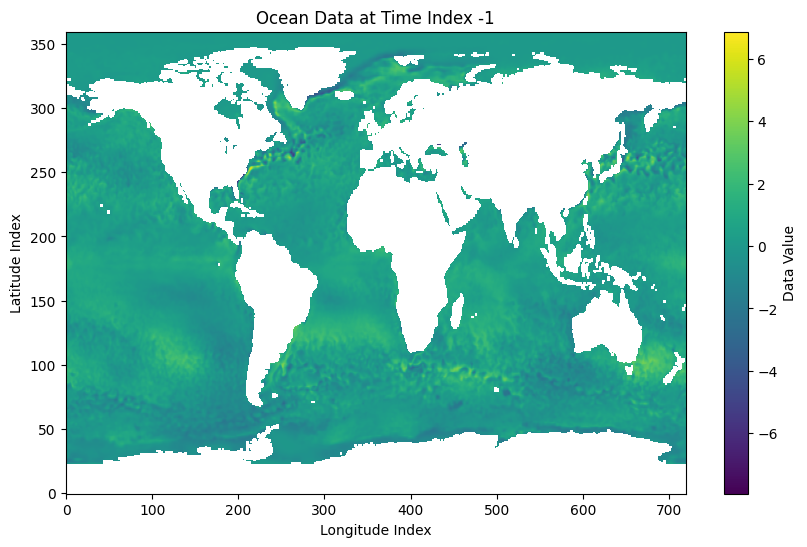

In [22]:
sst = ds_resampled['sst'].values
anom = ds_resampled['anom'].values
plot_ocean_data(anom, -1)

In [26]:
# 保存anom数据
sst_ds = ds_resampled['anom'].rename('data')
# sst_ds = sst_ds.roll(lon=len(sst_ds.lon) // 2, roll_coords=True)

# 查看结果
print(sst_ds)

output_file = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/oisst_199301_201901_monthly_down.nc'
sst_ds.to_netcdf(output_file)


<xarray.DataArray 'data' (time: 313, lat: 360, lon: 720)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.00419355, 0.00419355, 0.00419355, ..., 0.00419355,
         0.00419355, 0.00419355],
        [0.00419355, 0.00419355, 0.00419355, ..., 0.00419355,
         0.00419355, 0.00419355],
        [0.00451613, 0.00451613, 0.00451613, ..., 0.00451613,
         0.00451613, 0.00451613]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [0.11610023, 0.12513064, 0.13448379, ..., 0.0825860

In [27]:
saved_sst = xr.open_dataset(output_file)
print(saved_sst)

<xarray.Dataset>
Dimensions:  (time: 313, lat: 360, lon: 720)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
  * lat      (lat) float64 -89.88 -89.37 -88.87 -88.37 ... 88.87 89.37 89.88
  * lon      (lon) float64 -179.9 -179.4 -178.9 -178.4 ... 178.9 179.4 179.9
Data variables:
    data     (time, lat, lon) float64 ...


## SLA数据

time: 313, latitude: 719, longitude: 1439

In [32]:
path = '/home/data2/pengguohang/My_Ocean/CMEMS/sla_1993_2019/sla_1993_2019.nc'
ds = xr.open_dataset(path)
print(ds)

is_all_nan = ds['sla'].isnull().all()

print("Is 'sla' variable all NaN?", is_all_nan)

<xarray.Dataset>
Dimensions:    (time: 313, latitude: 720, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
Data variables:
    sla        (time, latitude, longitude) float64 ...
Attributes: (12/43)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Monthly Mean of Sea Level Anomalies refe...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               1993-01-31T00:00:00Z
    time_coverage_resolution:        P1M
    time_coverage_start:     

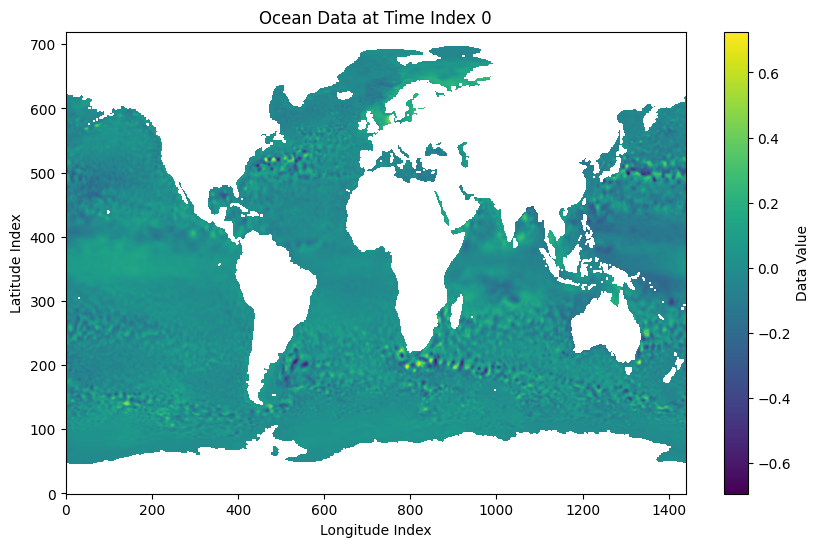

In [33]:
sla = ds['sla'].values
plot_ocean_data(sla, 0)

In [37]:
# 降采样
# 降为0.5*0.5

# 原始经纬度
original_lat = ds['latitude']
original_lon = ds['longitude']

# 降采样后的纬度和经度
new_lat = np.linspace(original_lat.min(), original_lat.max(), 360)
new_lon = np.linspace(original_lon.min(), original_lon.max(), 720)

# 进行重网格化
ds_resampled = ds.interp(latitude=new_lat, longitude=new_lon)

# 统一变量命名
ds_resampled = ds_resampled.rename({'longitude': 'lon', 'latitude': 'lat'})
ds_resampled = ds_resampled.rename({'sla': 'data'})
print(ds_resampled)

ds_resampled.to_netcdf('/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/sla_199301_201901_monthly_down.nc')

<xarray.Dataset>
Dimensions:  (time: 313, lat: 360, lon: 720)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
  * lat      (lat) float64 -89.88 -89.37 -88.87 -88.37 ... 88.87 89.37 89.88
  * lon      (lon) float64 -179.9 -179.4 -178.9 -178.4 ... 178.9 179.4 179.9
Data variables:
    data     (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/43)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Monthly Mean of Sea Level Anomalies refe...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               1993-01-31T00:00:00Z
    time_coverage_resolution:        P1M
    time_coverage_start

## MDT数据

In [120]:
path = '/home/data2/pengguohang/My_Ocean/AVISO+/mdt_cnes_cls18_global.nc'

ds = xr.open_dataset(path)
print(ds)
# print(ds.keys())
mdt = ds['mdt']
print(mdt)

<xarray.Dataset>
Dimensions:    (time: 1, latitude: 1440, nv: 2, longitude: 2880)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01
  * latitude   (latitude) float32 -89.94 -89.81 -89.69 ... 89.69 89.81 89.94
  * longitude  (longitude) float32 0.0625 0.1875 0.3125 ... 359.7 359.8 359.9
  * nv         (nv) int32 0 1
Data variables:
    lat_bnds   (latitude, nv) float32 ...
    lon_bnds   (longitude, nv) float32 ...
    crs        int32 ...
    mdt        (time, latitude, longitude) float64 ...
    u          (time, latitude, longitude) float64 ...
    v          (time, latitude, longitude) float64 ...
    err_mdt    (time, latitude, longitude) float64 ...
    err_u      (time, latitude, longitude) float64 ...
    err_v      (time, latitude, longitude) float64 ...
Attributes: (12/25)
    cdm_data_type:              Grid
    Conventions:                CF-1.6
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    contact:                    aviso@altimetry.fr, smule

In [121]:
# 将经度从0到360转换为-180到180
ds = ds.rename({
    'longitude': 'lon',
    'latitude': 'lat'
})
ds_2 = ds.assign_coords(lon=((ds.lon - 180) % 360) - 180)

# 仅选择mdt数据
ds_mdt = ds_2['mdt']
ds_mdt = ds_mdt.roll(lon=len(ds_mdt.lon) // 2, roll_coords=True)
ds_mdt = ds_mdt.rename('data')

print(ds_mdt)

<xarray.DataArray 'data' (time: 1, lat: 1440, lon: 2880)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01
  * lat      (lat) float32 -89.94 -89.81 -89.69 -89.56 ... 89.69 89.81 89.94
  * lon      (lon) float32 -179.9 -179.8 -179.7 -179.6 ... 179.7 179.8 179.9
Attributes:
    limitations:    No data in the Mediterranean Sea
    long_name:      mean dynamic topography
    standard_name:  mean_dynamic_topography
    units:          m
    grid_mapping:   crs


In [122]:
# 降采样 降为0.5*0.5

# 原始经纬度
original_lat = ds_mdt['lat']
original_lon = ds_mdt['lon']

# 降采样后的纬度和经度
new_lat = np.linspace(original_lat.min(), original_lat.max(), 360)
new_lon = np.linspace(original_lon.min(), original_lon.max(), 720)

# 进行重网格化
ds_resampled = ds_mdt.interp(lat=new_lat, lon=new_lon)

print(ds_resampled)

<xarray.DataArray 'data' (time: 1, lat: 360, lon: 720)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01
  * lat      (lat) float64 -89.94 -89.44 -88.94 -88.43 ... 88.94 89.44 89.94
  * lon      (lon) float64 -179.9 -179.4 -178.9 -178.4 ... 178.9 179.4 179.9
Attributes:
    limitations:    No data in the Mediterranean Sea
    long_name:      mean dynamic topography
    standard_name:  mean_dynamic_topography
    units:          m
    grid_mapping:   crs


<xarray.DataArray 'data' (time: 1, lat: 360, lon: 720)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01
  * lon      (lon) float64 -179.9 -179.4 -178.9 -178.4 ... 178.9 179.4 179.9
  * lat      (lat) float64 -89.88 -89.37 -88.87 -88.37 ... 88.87 89.37 89.88
Attributes:
    limitations:    No data in the Mediterranean Sea
    long_name:      mean dynamic topography
    standard_name:  mean_dynamic_topography
    units:          m
    grid_mapping:   crs


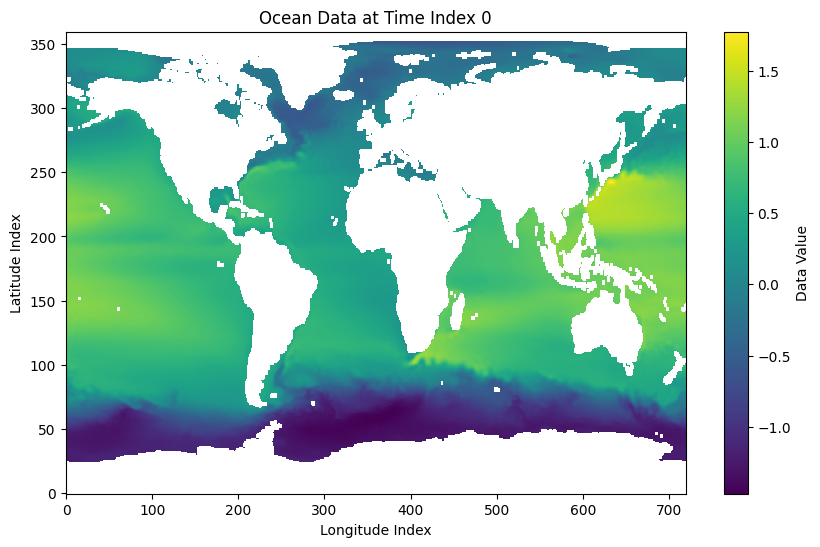

In [124]:
# 使用sst的经纬度网格
ds_sst = xr.open_dataset('/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/oisst_199301_201901_monthly_down.nc')
lon_std = ds_sst['lon'].values
lat_std = ds_sst['lat'].values

# 使用interp方法进行双线性插值
ds_resampled = ds_resampled.interp(lon=lon_std, lat=lat_std, method='linear')
print(ds_resampled)

mdt = ds_resampled.values
plot_ocean_data(mdt, 0)

In [125]:

# 创建一个新的时间坐标，包含313个相同的时间点
new_time = xr.DataArray(np.repeat(ds_resampled.time.values, 313), dims='time')
# 使用 xarray.concat 按照新的时间坐标重复 da
repeated_da = xr.concat([ds_resampled for _ in range(313)], dim=new_time)

# 对齐时间维度
new_times = pd.date_range(start='1993-01-01', end='2019-01-01', freq='MS')  # 新的时间序列：每个月的第一天
new_times = new_times.to_numpy()

# 更换time维度
ds_interp = repeated_da.drop('time')
repeated_da = repeated_da.assign_coords(time=new_times)
repeated_da = repeated_da.transpose('time', 'lat', 'lon')

print(repeated_da)

<xarray.DataArray 'data' (time: 313, lat: 360, lon: 720)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, .

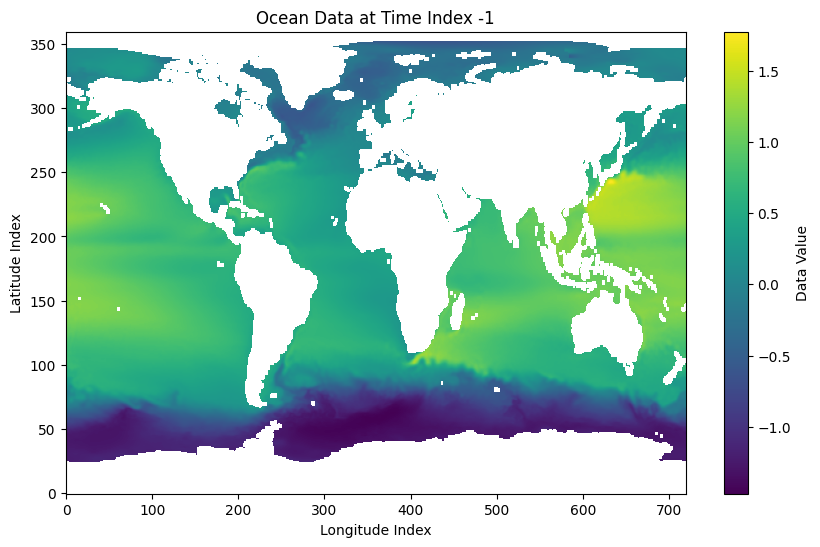

In [126]:
mdt = repeated_da.values
plot_ocean_data(mdt, -1)

In [127]:

output_file = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/mdt_cnes_cls18_global_down.nc'
repeated_da.to_netcdf(output_file)

ds = xr.open_dataset(output_file)
print(ds)

<xarray.Dataset>
Dimensions:  (time: 313, lon: 720, lat: 360)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
  * lon      (lon) float64 -179.9 -179.4 -178.9 -178.4 ... 178.9 179.4 179.9
  * lat      (lat) float64 -89.88 -89.37 -88.87 -88.37 ... 88.87 89.37 89.88
Data variables:
    data     (time, lat, lon) float64 ...


In [128]:
path = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/mdt_cnes_cls18_global_down.nc'
ds = xr.open_dataset(path)
print(ds)

<xarray.Dataset>
Dimensions:  (time: 313, lon: 720, lat: 360)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
  * lon      (lon) float64 -179.9 -179.4 -178.9 -178.4 ... 178.9 179.4 179.9
  * lat      (lat) float64 -89.88 -89.37 -88.87 -88.37 ... 88.87 89.37 89.88
Data variables:
    data     (time, lat, lon) float64 ...


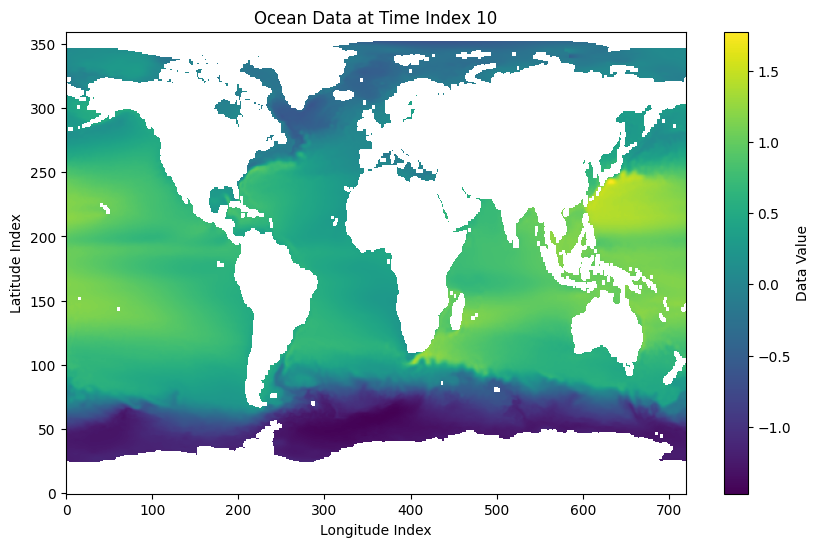

In [129]:
plot_ocean_data(ds['data'].values, 10)

## U V

有气候态数据

### 合并数据

In [20]:
folder_path = '/home/data2/pengguohang/My_Ocean/CCMP/ccmp_1993_201904_M'

file = os.path.join(folder_path, 'CCMP_Wind_Analysis_200201_V02.0_L3.5_RSS.nc')
ds = xr.open_dataset(file)
print(ds)

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 628, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * latitude   (latitude) float32 -78.38 -78.12 -77.88 ... 77.88 78.12 78.38
  * time       (time) datetime64[ns] 2002-01-15
Data variables:
    uwnd       (time, latitude, longitude) float32 ...
    vwnd       (time, latitude, longitude) float32 ...
Attributes: (12/36)
    contact:                    Remote Sensing Systems, support@remss.com
    Conventions:                CF-1.6
    data_structure:             grid
    title:                      RSS CCMP V2.0 monthly average derived surface...
    history:                    20160713T175743ZZ - netCDF generated from ori...
    description:                RSS monthly average of VAM 6-hour analyses st...
    ...                         ...
    contributor_name:           Joel Scott, Frank Wentz, Ross Hoffman, Mark L...
    contributor_role:           Software Engineer, 

In [21]:
# 合并每月数据,差了200201 - 已补充
files = sorted([f for f in os.listdir(folder_path) if f.endswith('.nc')])
print(len(files))
all_month_u = []
all_month_v = []
for file in files:
    file_path = os.path.join(folder_path, file)
    data = xr.open_dataset(file_path)
    u = data['uwnd']
    v = data['vwnd']

    all_month_u.append(u)
    all_month_v.append(v)
print('month: ', len(all_month_u), len(all_month_v))

u_data = xr.concat(all_month_u, 'time')
v_data = xr.concat(all_month_v, 'time')

# print(u_data)

313
month:  313 313


In [22]:
ds = xr.Dataset({
    'uwnd': u_data,
    'vwnd': v_data
})
print(ds)
# 将Dataset保存为NetCDF文件
ds.to_netcdf('/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/raw/uv_199301_201901_monthly.nc')


<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 628, time: 313)
Coordinates:
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * latitude   (latitude) float32 -78.38 -78.12 -77.88 ... 77.88 78.12 78.38
  * time       (time) datetime64[ns] 1993-01-16T09:00:00 ... 2019-01-16T09:00:00
Data variables:
    uwnd       (time, latitude, longitude) float32 -1.153 -1.145 ... -1.139 -1.2
    vwnd       (time, latitude, longitude) float32 -3.951 -3.973 ... -6.101


### 处理数据

In [85]:
# 读取数据处理维度
path = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/raw/uv_199301_201901_monthly.nc'
ds = xr.open_dataset(path)
print(ds)

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 628, time: 313)
Coordinates:
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * latitude   (latitude) float32 -78.38 -78.12 -77.88 ... 77.88 78.12 78.38
  * time       (time) datetime64[ns] 1993-01-16T09:00:00 ... 2019-01-16T09:00:00
Data variables:
    uwnd       (time, latitude, longitude) float32 ...
    vwnd       (time, latitude, longitude) float32 ...


(313, 628, 1440)


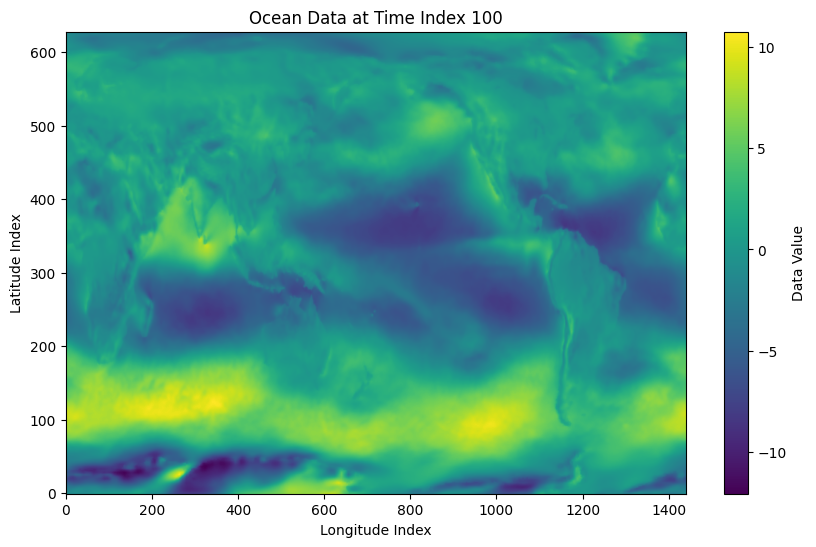

In [86]:
uwnd = ds['uwnd'].values
print(uwnd.shape)
plot_ocean_data(uwnd, 100)

In [87]:
# 降采样 降为0.5*0.5

# 原始经纬度
original_lat = ds['latitude']
original_lon = ds['longitude']

# 降采样后的纬度和经度
new_lat = np.linspace(original_lat.min(), original_lat.max(), 314)
new_lon = np.linspace(original_lon.min(), original_lon.max(), 720)

# 进行重网格化
ds_resampled = ds.interp(latitude=new_lat, longitude=new_lon)

print(ds_resampled)

<xarray.Dataset>
Dimensions:    (time: 313, latitude: 314, longitude: 720)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-16T09:00:00 ... 2019-01-16T09:00:00
  * latitude   (latitude) float64 -78.38 -77.87 -77.37 ... 77.37 77.87 78.38
  * longitude  (longitude) float64 0.125 0.6253 1.126 ... 358.9 359.4 359.9
Data variables:
    uwnd       (time, latitude, longitude) float64 -1.153 -1.137 ... -1.078 -1.2
    vwnd       (time, latitude, longitude) float64 -3.951 -3.994 ... -6.101


<xarray.Dataset>
Dimensions:    (time: 313, latitude: 314, longitude: 720)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-16T09:00:00 ... 2019-01-16T09:00:00
  * latitude   (latitude) float64 -78.38 -77.87 -77.37 ... 77.37 77.87 78.38
  * longitude  (longitude) float64 0.125 0.6253 1.126 ... -1.126 -0.6253 -0.125
Data variables:
    uwnd       (time, latitude, longitude) float64 -1.153 -1.137 ... -1.078 -1.2
    vwnd       (time, latitude, longitude) float64 -3.951 -3.994 ... -6.101


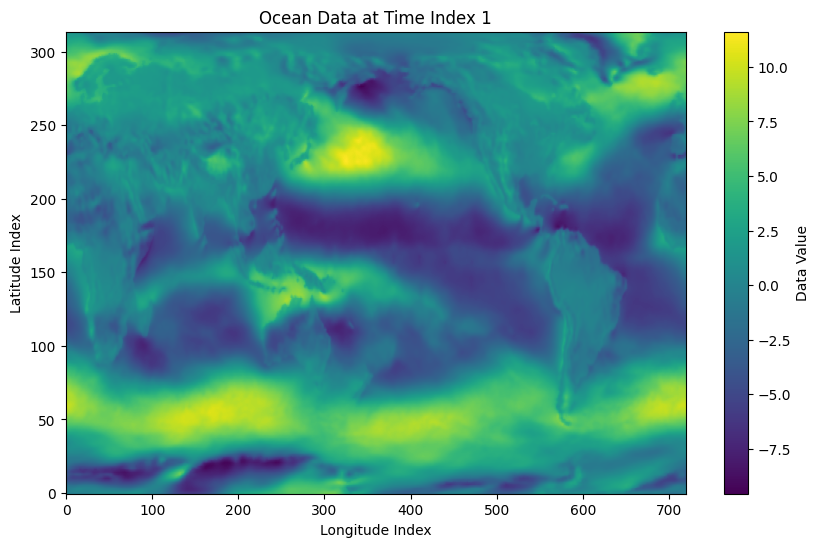

In [90]:
ds_resampled = ds_resampled.assign_coords(longitude=((ds_resampled.longitude - 180) % 360) - 180)
ds_resampled = ds_resampled.roll(longitude=len(ds_resampled.longitude) // 2, roll_coords=True)
print(ds_resampled)

data = ds_resampled['uwnd'].values
plot_ocean_data(data, 1)

In [101]:
# 插值到sst的标准经纬度上，lat外插的值均设为0
uwnd = ds_resampled['uwnd']
vwnd = ds_resampled['vwnd']

# 使用sst的经纬度网格
ds_sst = xr.open_dataset('/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/oisst_199301_201901_monthly_down.nc')
lon_std = ds_sst['lon'].values
lat_std = ds_sst['lat'].values

# 使用interp方法进行双线性插值
uwnd_interp = uwnd.interp(longitude=lon_std, latitude=lat_std, method='linear')
vwnd_interp = vwnd.interp(longitude=lon_std, latitude=lat_std, method='linear')

<xarray.Dataset>
Dimensions:    (time: 313, longitude: 720, latitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-16T09:00:00 ... 2019-01-16T09:00:00
  * longitude  (longitude) float64 -179.9 -179.4 -178.9 ... 178.9 179.4 179.9
  * latitude   (latitude) float64 -89.88 -89.37 -88.87 ... 88.87 89.37 89.88
Data variables:
    uwnd       (time, latitude, longitude) float64 nan nan nan ... nan nan nan
    vwnd       (time, latitude, longitude) float64 nan nan nan ... nan nan nan


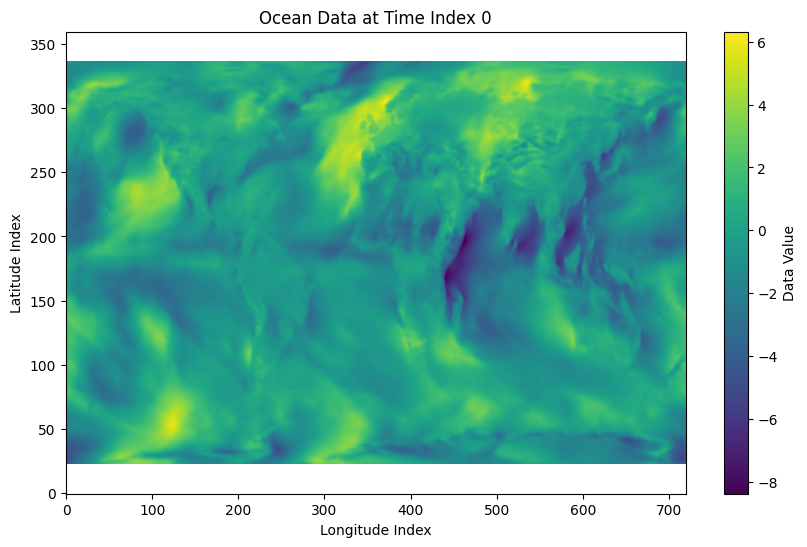

In [102]:
def compute_climatological_mean_and_anomalies(data):
    """
    计算每个变量的气候学平均值, 从而计算其异常值
    input: data (xarray.Dataset or xarray.DataArray): 包含多个变量的时间序列数据，维度为 (time, lat, lon)。
    return: xarray.Dataset or xarray.DataArray: 包含异常值的数据集，维度为 (time, lat, lon)。
    """
    
    # 计算气候学平均值（沿着time维度求平均）
    clim_mean = data.mean(dim='time')
    clim_mean_expanded = clim_mean.broadcast_like(data)
    anomalies = data - clim_mean_expanded
    
    return anomalies

vwnd_anom = compute_climatological_mean_and_anomalies(vwnd_interp)
uwnd_anom = compute_climatological_mean_and_anomalies(uwnd_interp)

ds_interp = xr.Dataset({'uwnd': vwnd_anom, 'vwnd': uwnd_anom})
# ds_interp = ds_interp.expand_dims('time').assign_coords(time=ds_resampled['time'])
# ds_interp = ds_interp.expand_dims('lat').assign_coords(time=ds_resampled['latitude'])
# ds_interp = ds_interp.expand_dims('lon').assign_coords(time=ds_resampled['longitude'])

print(ds_interp)
data =vwnd_anom.values
plot_ocean_data(data, 0)

In [103]:
# 重命名坐标轴名称
ds_interp = ds_interp.rename({'longitude': 'lon', 'latitude': 'lat'})
# 对齐时间维度
new_times = pd.date_range(start='1993-01-01', end='2019-01-01', freq='MS')  # 新的时间序列：每个月的第一天
new_times = new_times.to_numpy()

# 更换time维度
ds_interp = ds_interp.drop('time')
ds_interp = ds_interp.assign_coords(time=new_times)
ds_interp = ds_interp.transpose('time', 'lat', 'lon')

# ds_interp = ds_interp.roll(lon=len(ds_interp.lon) // 2, roll_coords=True)

uwnd = ds_interp['uwnd']
uwnd = uwnd.rename('data')
output_file = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/u_199301_201901_monthly_down.nc'
uwnd.to_netcdf(output_file)

vwnd = ds_interp['vwnd']
vwnd = vwnd.rename('data')
output_file = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/v_199301_201901_monthly_down.nc'
vwnd.to_netcdf(output_file)

print(uwnd)

<xarray.DataArray 'data' (time: 313, lat: 360, lon: 720)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, .

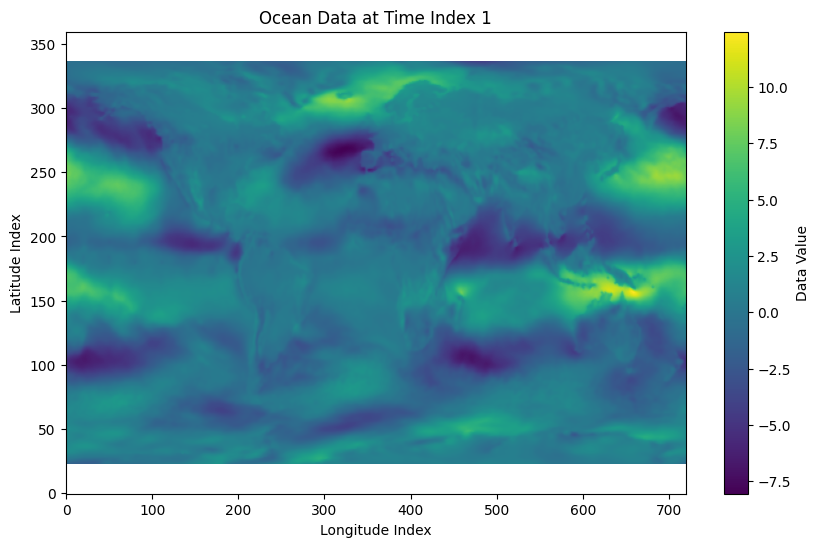

In [104]:
vwnd = vwnd.values
plot_ocean_data(vwnd, 1)

<xarray.DataArray 'data' ()>
array(12.3623227) <xarray.DataArray 'data' ()>
array(-11.53194086)


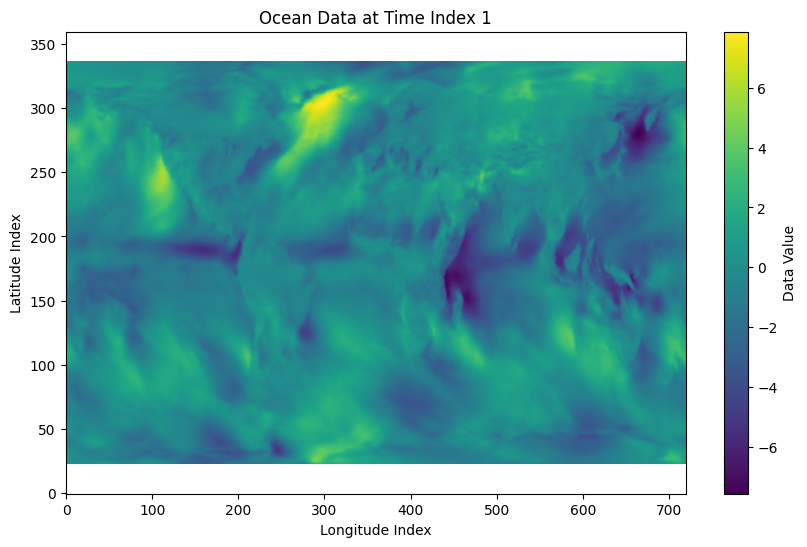

In [105]:

print(np.max(uwnd), np.min(uwnd))
plot_ocean_data(uwnd, 1)

### 气候态数据

In [25]:
# 减去气候态，得异常值
cli_path = '/home/data2/pengguohang/My_Ocean/CCMP/ccmp_1993_201904_M/climatology/CCMP_Wind_Analysis_climatology_V02.0_L3.5_RSS.nc'

ds = xr.open_dataset(cli_path)

u_cli = xr.concat([ds['uwnd']] * 26, dim="time")  # 26年的数据，复制26次(1993-2018)
u_cli = xr.concat([u_cli, u_cli[0]], dim="time")  # 再加上1月(201901)
v_cli = xr.concat([ds['vwnd']] * 26, dim="time") 
v_cli = xr.concat([v_cli, v_cli[0]], dim="time") 
print(u_cli)

<xarray.DataArray 'uwnd' (time: 313, latitude: 628, longitude: 1440)>
array([[[-0.31168702, -0.3000436 , -0.28836942, ..., -0.36129946,
         -0.34378788, -0.3262663 ],
        [-0.3228996 , -0.3089281 , -0.29492548, ..., -0.3736735 ,
         -0.35615945, -0.3386413 ],
        [-0.35003674, -0.33497053, -0.31985798, ..., -0.39469376,
         -0.37987018, -0.36500937],
        ...,
        [-1.0170398 , -1.0413331 , -1.0649663 , ..., -0.9398833 ,
         -0.9656166 , -0.9916063 ],
        [-1.0181438 , -1.0422156 , -1.066426  , ..., -0.9422262 ,
         -0.96773994, -0.99332154],
        [-0.9641303 , -0.98295844, -1.002096  , ..., -0.90434444,
         -0.9245906 , -0.94467676]],

       [[-0.6262838 , -0.6073647 , -0.58839995, ..., -0.71120757,
         -0.6810294 , -0.650835  ],
        [-0.6276358 , -0.6037389 , -0.5798019 , ..., -0.7141342 ,
         -0.68431073, -0.65448946],
        [-0.6594627 , -0.63235736, -0.60516256, ..., -0.73476195,
         -0.7100824 , -0.6853671 

## SSS

In [4]:
path = '/home/data2/pengguohang/My_Ocean/CMEMS/sss_199301_201901_monthly/cmems_obs-mob_glo_phy-sss_my_multi_P1M_sos_179.94W-179.94E_89.94S-89.94N_0.00m_1993-01-01-2019-01-01.nc'
ds = xr.open_dataset(path)
print(ds)

<xarray.Dataset>
Dimensions:    (time: 313, depth: 1, latitude: 1440, longitude: 2880)
Coordinates:
  * depth      (depth) float32 0.0
  * latitude   (latitude) float32 -89.94 -89.81 -89.69 ... 89.69 89.81 89.94
  * longitude  (longitude) float32 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
Data variables:
    sos        (time, depth, latitude, longitude) float32 ...
Attributes: (12/20)
    Conventions:               CF-1.7
    Scaling_Equation:          (scale_factor*data) + add_offset
    contact:                   servicedesk.cmems@mercator-ocean.eu
    creation_date:             Sat 12 Aug 2023 11:07:53
    date:                      Sat 07 Oct 2023 12:34:08 /store2/MOB/SSS_SSD_A...
    easternmost_longitude:     359.9375
    ...                        ...
    references:                Buongiorno Nardelli, B., R. Droghei, and R. Sa...
    software_version:          SSS/SSD HR Processor v1.0
    southernmost_la

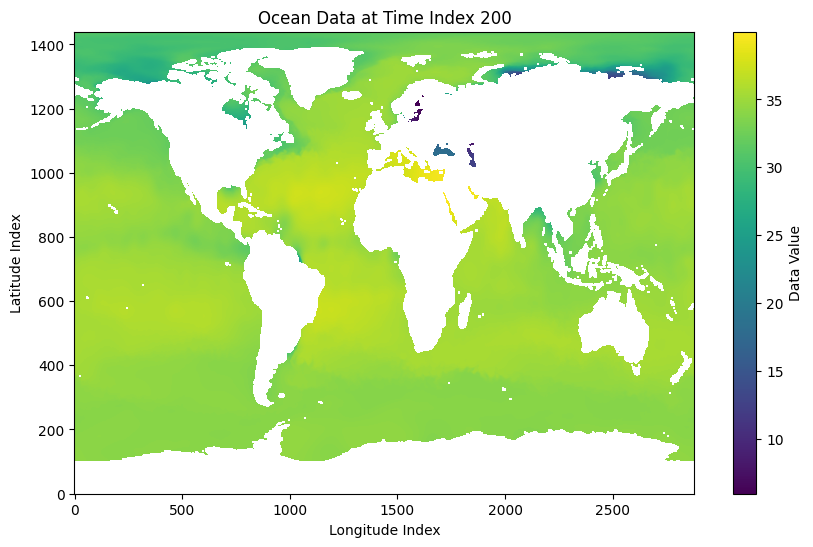

In [5]:
sss = ds['sos'].values[: ,0, ...]
plot_ocean_data(sss, 200)

In [6]:
# 降采样 降为0.5*0.5

# 原始经纬度
original_lat = ds['latitude']
original_lon = ds['longitude']

# 降采样后的纬度和经度
new_lat = np.linspace(original_lat.min(), original_lat.max(), 360)
new_lon = np.linspace(original_lon.min(), original_lon.max(), 720)

# 进行重网格化
ds_resampled = ds.interp(latitude=new_lat, longitude=new_lon)

print(ds_resampled)

<xarray.Dataset>
Dimensions:    (time: 313, depth: 1, latitude: 360, longitude: 720)
Coordinates:
  * depth      (depth) float32 0.0
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
  * latitude   (latitude) float64 -89.94 -89.44 -88.94 ... 88.94 89.44 89.94
  * longitude  (longitude) float64 -179.9 -179.4 -178.9 ... 178.9 179.4 179.9
Data variables:
    sos        (time, depth, latitude, longitude) float64 nan nan ... nan nan
Attributes: (12/20)
    Conventions:               CF-1.7
    Scaling_Equation:          (scale_factor*data) + add_offset
    contact:                   servicedesk.cmems@mercator-ocean.eu
    creation_date:             Sat 12 Aug 2023 11:07:53
    date:                      Sat 07 Oct 2023 12:34:08 /store2/MOB/SSS_SSD_A...
    easternmost_longitude:     359.9375
    ...                        ...
    references:                Buongiorno Nardelli, B., R. Droghei, and R. Sa...
    software_version:          SSS/SSD HR Processor v1.0
    s

In [7]:
# 使用双线性插值，将数据插值到SST的经纬度坐标上
sst_path = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/oisst_199301_201901_monthly_down.nc'
sst_ds = xr.open_dataset(sst_path)

new_lat = xr.DataArray(sst_ds.lat, dims="lat", coords={"lat": sst_ds.lat})
new_lon = xr.DataArray(sst_ds.lon, dims="lon", coords={"lon": sst_ds.lon})
# print(new_lat, new_lon)

# # 执行双线性插值
ds_interp = ds_resampled.interp(latitude=new_lat, longitude=new_lon, method="linear")

# # 输出检查插值后的数据
print(ds_interp)

<xarray.Dataset>
Dimensions:    (time: 313, depth: 1, lat: 360, lon: 720)
Coordinates:
  * depth      (depth) float32 0.0
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
    latitude   (lat) float64 -89.88 -89.37 -88.87 -88.37 ... 88.87 89.37 89.88
    longitude  (lon) float64 -179.9 -179.4 -178.9 -178.4 ... 178.9 179.4 179.9
  * lat        (lat) float64 -89.88 -89.37 -88.87 -88.37 ... 88.87 89.37 89.88
  * lon        (lon) float64 -179.9 -179.4 -178.9 -178.4 ... 178.9 179.4 179.9
Data variables:
    sos        (time, depth, lat, lon) float64 nan nan nan nan ... nan nan nan
Attributes: (12/20)
    Conventions:               CF-1.7
    Scaling_Equation:          (scale_factor*data) + add_offset
    contact:                   servicedesk.cmems@mercator-ocean.eu
    creation_date:             Sat 12 Aug 2023 11:07:53
    date:                      Sat 07 Oct 2023 12:34:08 /store2/MOB/SSS_SSD_A...
    easternmost_longitude:     359.9375
    ...                    

In [8]:
# 统一名称，删去坐标depth latitude logitude
ds_interp = ds_interp.squeeze(dim='depth')
ds_interp = ds_interp.drop('depth')
ds_interp = ds_interp.drop('latitude')
ds_interp = ds_interp.drop('longitude')
ds_interp = ds_interp.rename({'sos': 'data'})


def compute_climatological_mean_and_anomalies(data):
    """
    计算每个变量的气候学平均值, 从而计算其异常值
    input: data (xarray.Dataset or xarray.DataArray): 包含多个变量的时间序列数据，维度为 (time, lat, lon)。
    return: xarray.Dataset or xarray.DataArray: 包含异常值的数据集，维度为 (time, lat, lon)。
    """
    
    # 计算气候学平均值（沿着time维度求平均）
    clim_mean = data.mean(dim='time')
    clim_mean_expanded = clim_mean.broadcast_like(data)
    anomalies = data - clim_mean_expanded
    
    return anomalies

ds_anom = compute_climatological_mean_and_anomalies(ds_interp)

print(ds_anom)

output_file = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/sss_l4_199301_201901_monthly_down.nc'
ds_interp.to_netcdf(output_file)

<xarray.Dataset>
Dimensions:  (time: 313, lat: 360, lon: 720)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
  * lat      (lat) float64 -89.88 -89.37 -88.87 -88.37 ... 88.87 89.37 89.88
  * lon      (lon) float64 -179.9 -179.4 -178.9 -178.4 ... 178.9 179.4 179.9
Data variables:
    data     (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan


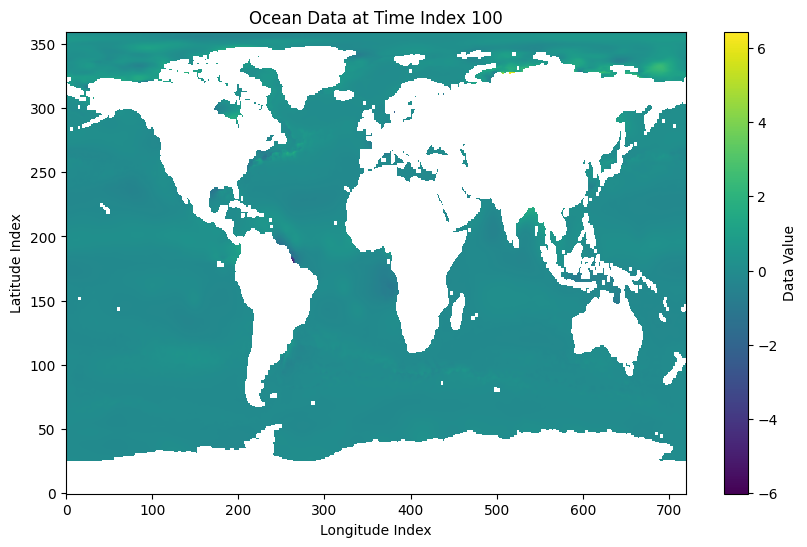

In [12]:
sss = ds_anom['data'].values
plot_ocean_data(sss, 100)

## CORA

In [3]:
path_s = '/home/data2/pengguohang/My_Ocean/CMEMS/CORA_1993_2019_P1M/CORA_199301_201901_PSAL_P1M.nc'
path_t = '/home/data2/pengguohang/My_Ocean/CMEMS/CORA_1993_2019_P1M/CORA_199301_201901_TEMP_P1M.nc'

sds = xr.open_dataset(path_s)
tds = xr.open_dataset(path_t)
print(sds)


path_sst = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/oisst_199301_201901_monthly_down.nc'
sst = xr.open_dataset(path_sst)
# print(sst)

<xarray.Dataset>
Dimensions:    (depth: 102, latitude: 1671, longitude: 720, time: 313)
Coordinates:
  * depth      (depth) float32 1.0 3.0 5.0 10.0 15.0 ... 940.0 960.0 980.0 1e+03
  * latitude   (latitude) float64 -77.0 -76.9 -76.8 -76.7 ... 89.8 89.9 90.0
  * longitude  (longitude) float64 -180.0 -179.5 -179.0 ... 178.5 179.0 179.5
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
Data variables:
    PSAL       (time, depth, latitude, longitude) float32 ...
Attributes: (12/22)
    Conventions:               CF-1.4
    analysis_name:             OA_CORA5.2_
    comment:                   V8.0 reference climatology and analysis parame...
    creation_date:             20230926T220219L
    data_manager:              Tanguy Szekely
    easternmost_longitude:     179.5
    ...                        ...
    southernmost_latitude:     -77.0105
    start_date:                2022-12-15
    stop_date:                 2022-12-15
    title:                     Global O

In [4]:
1671/4

417.75

In [5]:
# 截取需要的深度
my_depth_indices = [0, 3, 7, 15, 21, 26, 31, 41, 51, 61, 71, 81, 91, 96, 101]

# 使用 isel 方法按照深度索引截取数据
s_subset = sds.isel(depth=my_depth_indices)
t_subset = tds.isel(depth=my_depth_indices)

# 打印截取后的数据以确认
print(s_subset)

<xarray.Dataset>
Dimensions:    (depth: 15, latitude: 1671, longitude: 720, time: 313)
Coordinates:
  * depth      (depth) float32 1.0 10.0 30.0 70.0 ... 700.0 800.0 900.0 1e+03
  * latitude   (latitude) float64 -77.0 -76.9 -76.8 -76.7 ... 89.8 89.9 90.0
  * longitude  (longitude) float64 -180.0 -179.5 -179.0 ... 178.5 179.0 179.5
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
Data variables:
    PSAL       (time, depth, latitude, longitude) float32 ...
Attributes: (12/22)
    Conventions:               CF-1.4
    analysis_name:             OA_CORA5.2_
    comment:                   V8.0 reference climatology and analysis parame...
    creation_date:             20230926T220219L
    data_manager:              Tanguy Szekely
    easternmost_longitude:     179.5
    ...                        ...
    southernmost_latitude:     -77.0105
    start_date:                2022-12-15
    stop_date:                 2022-12-15
    title:                     Global Ocean

In [6]:
# 降采样 降为0.5*0.5

# 原始经纬度
original_lat = s_subset['latitude']
original_lon = s_subset['longitude']

# 降采样后的纬度和经度
new_lat = np.linspace(original_lat.min(), original_lat.max(), 417)
new_lon = np.linspace(original_lon.min(), original_lon.max(), 720)

# 进行重网格化
s_resampled = s_subset.interp(latitude=new_lat, longitude=new_lon)
t_resampled = t_subset.interp(latitude=new_lat, longitude=new_lon)

print(t_resampled)

<xarray.Dataset>
Dimensions:    (depth: 15, time: 313, latitude: 417, longitude: 720)
Coordinates:
  * depth      (depth) float32 1.0 10.0 30.0 70.0 ... 700.0 800.0 900.0 1e+03
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
  * latitude   (latitude) float64 -77.0 -76.6 -76.2 -75.8 ... 89.2 89.6 90.0
  * longitude  (longitude) float64 -180.0 -179.5 -179.0 ... 178.5 179.0 179.5
Data variables:
    TEMP       (time, depth, latitude, longitude) float64 -0.8111 ... nan
Attributes: (12/22)
    Conventions:               CF-1.4
    analysis_name:             OA_CORA5.2_
    comment:                   V8.0 reference climatology and analysis parame...
    creation_date:             20230926T220219L
    data_manager:              Tanguy Szekely
    easternmost_longitude:     179.5
    ...                        ...
    southernmost_latitude:     -77.0105
    start_date:                2022-12-15
    stop_date:                 2022-12-15
    title:                     G

<xarray.Dataset>
Dimensions:    (depth: 15, time: 313, latitude: 417, longitude: 720)
Coordinates:
  * depth      (depth) float32 1.0 10.0 30.0 70.0 ... 700.0 800.0 900.0 1e+03
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
  * latitude   (latitude) float64 -77.0 -76.6 -76.2 -75.8 ... 89.2 89.6 90.0
  * longitude  (longitude) float64 -180.0 -179.5 -179.0 ... 178.5 179.0 179.5
Data variables:
    PSAL       (time, depth, latitude, longitude) float64 34.21 34.17 ... nan
Attributes: (12/22)
    Conventions:               CF-1.4
    analysis_name:             OA_CORA5.2_
    comment:                   V8.0 reference climatology and analysis parame...
    creation_date:             20230926T220219L
    data_manager:              Tanguy Szekely
    easternmost_longitude:     179.5
    ...                        ...
    southernmost_latitude:     -77.0105
    start_date:                2022-12-15
    stop_date:                 2022-12-15
    title:                  

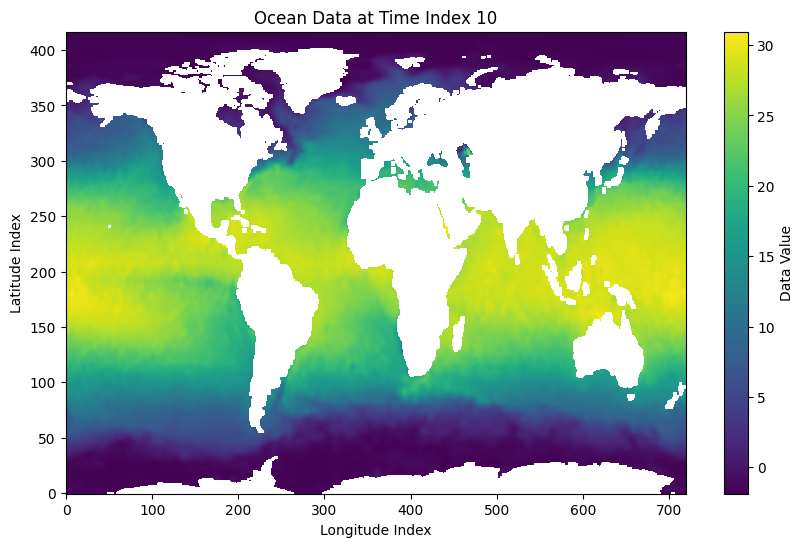

In [20]:
print(s_resampled)
s_data = s_resampled['PSAL'].values[:, 0, ...]
t_data = t_resampled['TEMP'].values[:, 0, ...]
plot_ocean_data(t_data, 10)

In [15]:
# # 下采样
# sds_sresampled = s_subset.coarsen(latitude=4, longitude=1, boundary="trim").mean()
# tds_sresampled = t_subset.coarsen(latitude=4, longitude=1, boundary="trim").mean()

In [21]:
# 插值到sst网格
lon_std = sst['lon'].values 
lat_std = sst['lat'].values
sda_interp = s_resampled.interp(longitude=lon_std, latitude=lat_std, method='linear')  # 使用interp方法进行双线性插值
tda_interp = t_resampled.interp(longitude=lon_std, latitude=lat_std, method='linear')

<xarray.Dataset>
Dimensions:    (depth: 15, time: 313, latitude: 360, longitude: 720)
Coordinates:
  * depth      (depth) float32 1.0 10.0 30.0 70.0 ... 700.0 800.0 900.0 1e+03
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
  * longitude  (longitude) float64 -179.9 -179.4 -178.9 ... 178.9 179.4 179.9
  * latitude   (latitude) float64 -89.88 -89.37 -88.87 ... 88.87 89.37 89.88
Data variables:
    PSAL       (time, depth, latitude, longitude) float64 nan nan ... nan nan
Attributes: (12/22)
    Conventions:               CF-1.4
    analysis_name:             OA_CORA5.2_
    comment:                   V8.0 reference climatology and analysis parame...
    creation_date:             20230926T220219L
    data_manager:              Tanguy Szekely
    easternmost_longitude:     179.5
    ...                        ...
    southernmost_latitude:     -77.0105
    start_date:                2022-12-15
    stop_date:                 2022-12-15
    title:                  

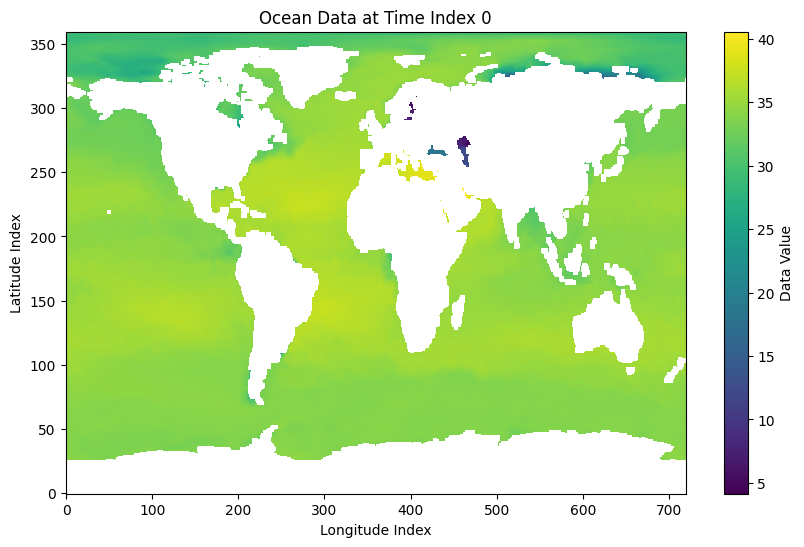

In [23]:
print(sda_interp)

data = sda_interp['PSAL'].values[:, 0, ...]
plot_ocean_data(data, 0)

In [24]:
sda_interp = sda_interp.rename({'longitude': 'lon', 'latitude': 'lat', 'PSAL': 'data'})
tda_interp = tda_interp.rename({'longitude': 'lon', 'latitude': 'lat', 'TEMP': 'data'})

print(sda_interp)
print(tda_interp)

<xarray.Dataset>
Dimensions:  (depth: 15, time: 313, lat: 360, lon: 720)
Coordinates:
  * depth    (depth) float32 1.0 10.0 30.0 70.0 ... 700.0 800.0 900.0 1e+03
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
  * lon      (lon) float64 -179.9 -179.4 -178.9 -178.4 ... 178.9 179.4 179.9
  * lat      (lat) float64 -89.88 -89.37 -88.87 -88.37 ... 88.87 89.37 89.88
Data variables:
    data     (time, depth, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes: (12/22)
    Conventions:               CF-1.4
    analysis_name:             OA_CORA5.2_
    comment:                   V8.0 reference climatology and analysis parame...
    creation_date:             20230926T220219L
    data_manager:              Tanguy Szekely
    easternmost_longitude:     179.5
    ...                        ...
    southernmost_latitude:     -77.0105
    start_date:                2022-12-15
    stop_date:                 2022-12-15
    title:                     Global Ocean

In [25]:
def compute_climatological_mean_and_anomalies(data):
    """
    计算每个变量的气候学平均值, 从而计算其异常值
    input: data (xarray.Dataset or xarray.DataArray): 包含多个变量的时间序列数据，维度为 (time, lat, lon)。
    return: xarray.Dataset or xarray.DataArray: 包含异常值的数据集，维度为 (time, lat, lon)。
    """
    
    # 计算气候学平均值（沿着time维度求平均）
    clim_mean = data.mean(dim='time')
    clim_mean_expanded = clim_mean.broadcast_like(data)
    anomalies = data - clim_mean_expanded
    
    return anomalies

sda_anom = compute_climatological_mean_and_anomalies(sda_interp)
tda_anom = compute_climatological_mean_and_anomalies(tda_interp)

print(sda_anom)

<xarray.Dataset>
Dimensions:  (depth: 15, time: 313, lon: 720, lat: 360)
Coordinates:
  * depth    (depth) float32 1.0 10.0 30.0 70.0 ... 700.0 800.0 900.0 1e+03
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
  * lon      (lon) float64 -179.9 -179.4 -178.9 -178.4 ... 178.9 179.4 179.9
  * lat      (lat) float64 -89.88 -89.37 -88.87 -88.37 ... 88.87 89.37 89.88
Data variables:
    data     (time, depth, lat, lon) float64 nan nan nan nan ... nan nan nan nan


In [33]:
output_file = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/label/CORA_S_15depth.nc'
sda_anom.to_netcdf(output_file)

output_file = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/label/CORA_T_15depth.nc'
tda_anom.to_netcdf(output_file)

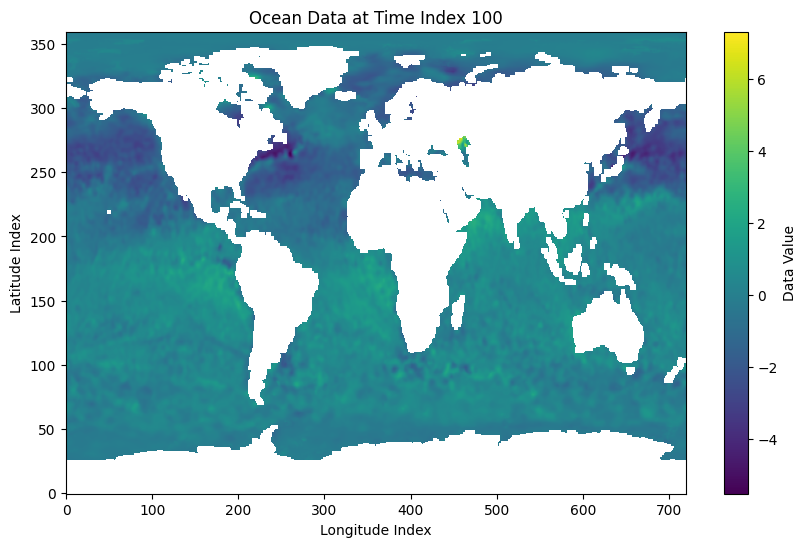

In [37]:
ss = tda_anom['data'][:, 0, ...]
plot_ocean_data(ss, 100)

In [268]:
# # 将不在这些边界内的点设置为0
# lat_min, lat_max = -77, 90
# print('设置边界： ', lat_min, lat_max)
# sda_interp_2 = xr.where(
#     (sda_interp.latitude >= lat_min) & (sda_interp.latitude <= lat_max),
#     sda_interp,
#     0
# )
# tda_interp_2 = xr.where(
#     (tda_interp.latitude >= lat_min) & (tda_interp.latitude <= lat_max),
#     tda_interp,
#     0
# )

# print(sda_interp_2)
# print(tda_interp_2)
# # print(ds_sresampled)

设置边界：  -77 90
<xarray.Dataset>
Dimensions:    (latitude: 180, time: 313, depth: 102, longitude: 360)
Coordinates:
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * depth      (depth) float32 1.0 3.0 5.0 10.0 15.0 ... 940.0 960.0 980.0 1e+03
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    PSAL       (latitude, time, depth, longitude) float64 0.0 0.0 ... nan nan
<xarray.Dataset>
Dimensions:    (latitude: 180, time: 313, depth: 102, longitude: 360)
Coordinates:
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * depth      (depth) float32 1.0 3.0 5.0 10.0 15.0 ... 940.0 960.0 980.0 1e+03
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    TEMP       (latitude, time, depth, longitude) float6

In [38]:
s_path = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/label/CORA_S_15depth.nc'
t_path = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/label/CORA_T_15depth.nc'
sds = xr.open_dataset(s_path)
tds = xr.open_dataset(t_path)
print(sds)
print(tds)
SS = sds['data']
ST = tds['data']
dataset = xr.Dataset({
    'S': SS,
    'T': ST
})
dataset.to_netcdf('/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/label/label.nc')

<xarray.Dataset>
Dimensions:  (depth: 15, time: 313, lon: 720, lat: 360)
Coordinates:
  * depth    (depth) float32 1.0 10.0 30.0 70.0 ... 700.0 800.0 900.0 1e+03
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
  * lon      (lon) float64 -179.9 -179.4 -178.9 -178.4 ... 178.9 179.4 179.9
  * lat      (lat) float64 -89.88 -89.37 -88.87 -88.37 ... 88.87 89.37 89.88
Data variables:
    data     (time, depth, lat, lon) float64 ...
<xarray.Dataset>
Dimensions:  (depth: 15, time: 313, lon: 720, lat: 360)
Coordinates:
  * depth    (depth) float32 1.0 10.0 30.0 70.0 ... 700.0 800.0 900.0 1e+03
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
  * lon      (lon) float64 -179.9 -179.4 -178.9 -178.4 ... 178.9 179.4 179.9
  * lat      (lat) float64 -89.88 -89.37 -88.87 -88.37 ... 88.87 89.37 89.88
Data variables:
    data     (time, depth, lat, lon) float64 ...


<xarray.Dataset>
Dimensions:  (depth: 15, time: 313, lon: 720, lat: 360)
Coordinates:
  * depth    (depth) float32 1.0 10.0 30.0 70.0 ... 700.0 800.0 900.0 1e+03
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
  * lon      (lon) float64 -179.9 -179.4 -178.9 -178.4 ... 178.9 179.4 179.9
  * lat      (lat) float64 -89.88 -89.37 -88.87 -88.37 ... 88.87 89.37 89.88
Data variables:
    S        (time, depth, lat, lon) float64 ...
    T        (time, depth, lat, lon) float64 ...


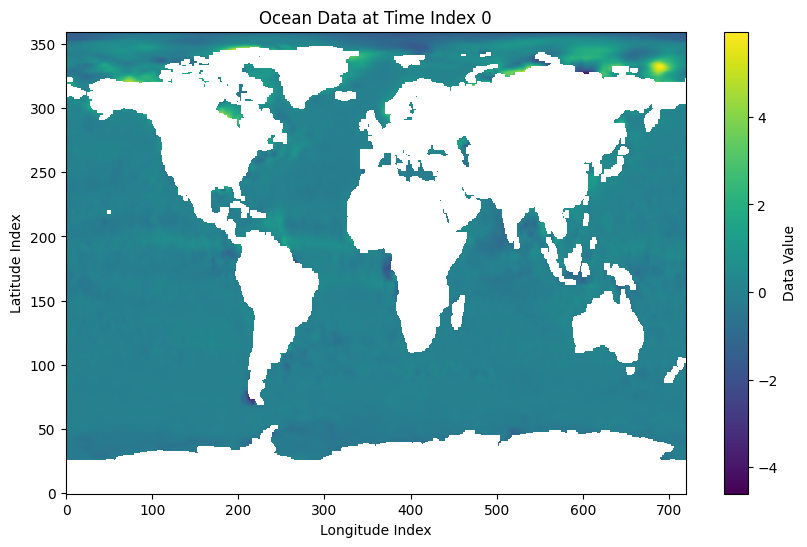

In [39]:
path = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/label/label.nc'
ds = xr.open_dataset(path)
print(ds)
ss = ds['S'].values
ss_0 = ss[:, 0, ...]
plot_ocean_data(ss_0, 0)

## dataset

In [43]:
# 将所有的文件合并在var维度并保存
def get_input_data(folder_path):
    """
    提取输入数据并拼接
    folder_path: 数据文件夹地址
    
    return:  (var, time, lat, lon)
    """
    # 1、提取文件名
    nc_files = [file for file in os.listdir(folder_path) if file.endswith('.nc')]
    # 存储数据
    data_all = []
    # 2、逐个加载.nc文件
    for file in nc_files:
        file_path = os.path.join(folder_path, file)
        print(f"Processing file: {file_path}")
        ds = xr.open_dataset(file_path)
        data_all.append(ds)

    # 将所有插值后的数据堆叠在一起
    data_all = xr.concat(data_all, dim='var').transpose("var", 'time', 'lat', 'lon')

    # print('shape of region:', data_all.shape)
    return data_all

path = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/'
data = get_input_data(path)
print(data)

output_file = "/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input.nc"
data.to_netcdf(output_file)

Processing file: /home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/mdt_cnes_cls18_global_down.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/sla_199301_201901_monthly_down.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/oisst_199301_201901_monthly_down.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/u_199301_201901_monthly_down.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/sss_l4_199301_201901_monthly_down.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/v_199301_201901_monthly_down.nc
<xarray.Dataset>
Dimensions:  (time: 313, lon: 720, lat: 360, var: 6)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
  * lon      (lon) float64 -179.9 -179.4 -178.9 -178.4 ... 178.9 179.4 179.9
  * lat      (lat) float64 -89.88 -89.37 -88.87 -88.37 ... 88.87 89.37 89.88
Dime

## 查看dataset

In [58]:
import matplotlib.pyplot as plt

def plot_multiple_ocean_data(data, indices):
    """
    绘制多个时刻的海洋数据子图。

    参数:
    - data: 海洋数据的三维数组，形状为(112, 120, 280)
    - indices: 要绘制的时刻索引列表（从0开始）

    返回:
    - 绘制的多个子图。
    """
    num_plots = len(indices)
    cols = min(num_plots, 3)  # 每行最多绘制3个子图
    rows = (num_plots + cols - 1) // cols  # 计算总行数

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), constrained_layout=True)
    axes = axes.flatten()  # 将子图数组展平，方便索引

    for idx, time_idx in enumerate(indices):
        time_data = data[time_idx, :, :]
        ax = axes[idx]
        im = ax.imshow(time_data, cmap='viridis', origin='lower', aspect='auto')
        ax.set_title(f'Time Index {time_idx}')
        ax.set_xlabel('Longitude Index')
        ax.set_ylabel('Latitude Index')
        plt.colorbar(im, ax=ax, shrink=0.8)

    # 如果子图数量小于网格中的子图数量，隐藏多余的子图
    for idx in range(num_plots, len(axes)):
        axes[idx].axis('off')

    plt.show()


In [3]:
input_path = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input.nc'
label_path = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/label.nc'

input_ds = xr.open_dataset(input_path)
label_ds = xr.open_dataset(label_path)

print(input_ds)
print(label_ds)

<xarray.Dataset>
Dimensions:  (time: 313, lon: 720, lat: 360, var: 6)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
  * lon      (lon) float64 -179.9 -179.4 -178.9 -178.4 ... 178.9 179.4 179.9
  * lat      (lat) float64 -89.88 -89.37 -88.87 -88.37 ... 88.87 89.37 89.88
Dimensions without coordinates: var
Data variables:
    data     (var, time, lat, lon) float64 ...
<xarray.Dataset>
Dimensions:  (depth: 15, time: 313, lon: 720, lat: 360)
Coordinates:
  * depth    (depth) float32 1.0 10.0 30.0 70.0 ... 700.0 800.0 900.0 1e+03
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
  * lon      (lon) float64 -179.9 -179.4 -178.9 -178.4 ... 178.9 179.4 179.9
  * lat      (lat) float64 -89.88 -89.37 -88.87 -88.37 ... 88.87 89.37 89.88
Data variables:
    S        (time, depth, lat, lon) float64 ...
    T        (time, depth, lat, lon) float64 ...


In [4]:
print(input_ds['data'].values.shape, label_ds['S'].values.shape, input_ds['lat'].values.shape, 
      input_ds['lon'].values.shape, label_ds['depth'].values.shape)



(6, 313, 360, 720) (313, 15, 360, 720) (360,) (720,) (15,)


(6, 313, 360, 720) (313, 15, 360, 720)


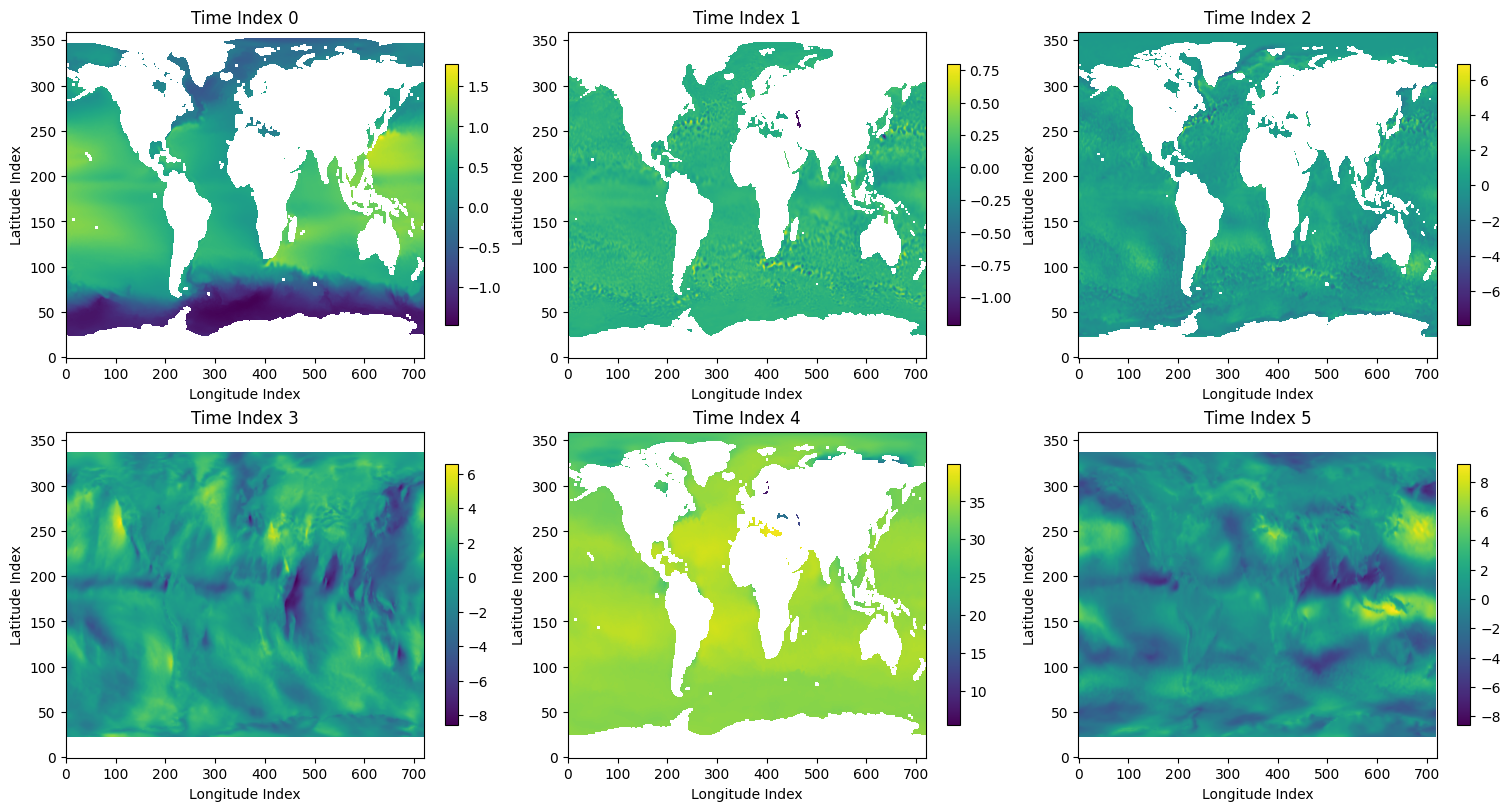

In [59]:
input = input_ds['data'].values
ss = label_ds['S'].values
st = label_ds['T'].values
lat = label_ds['lat'].values
lon = label_ds['lon'].values

print(input.shape, ss.shape)

plot_multiple_ocean_data(input[:, -1, ...], [0, 1, 2, 3, 4, 5])

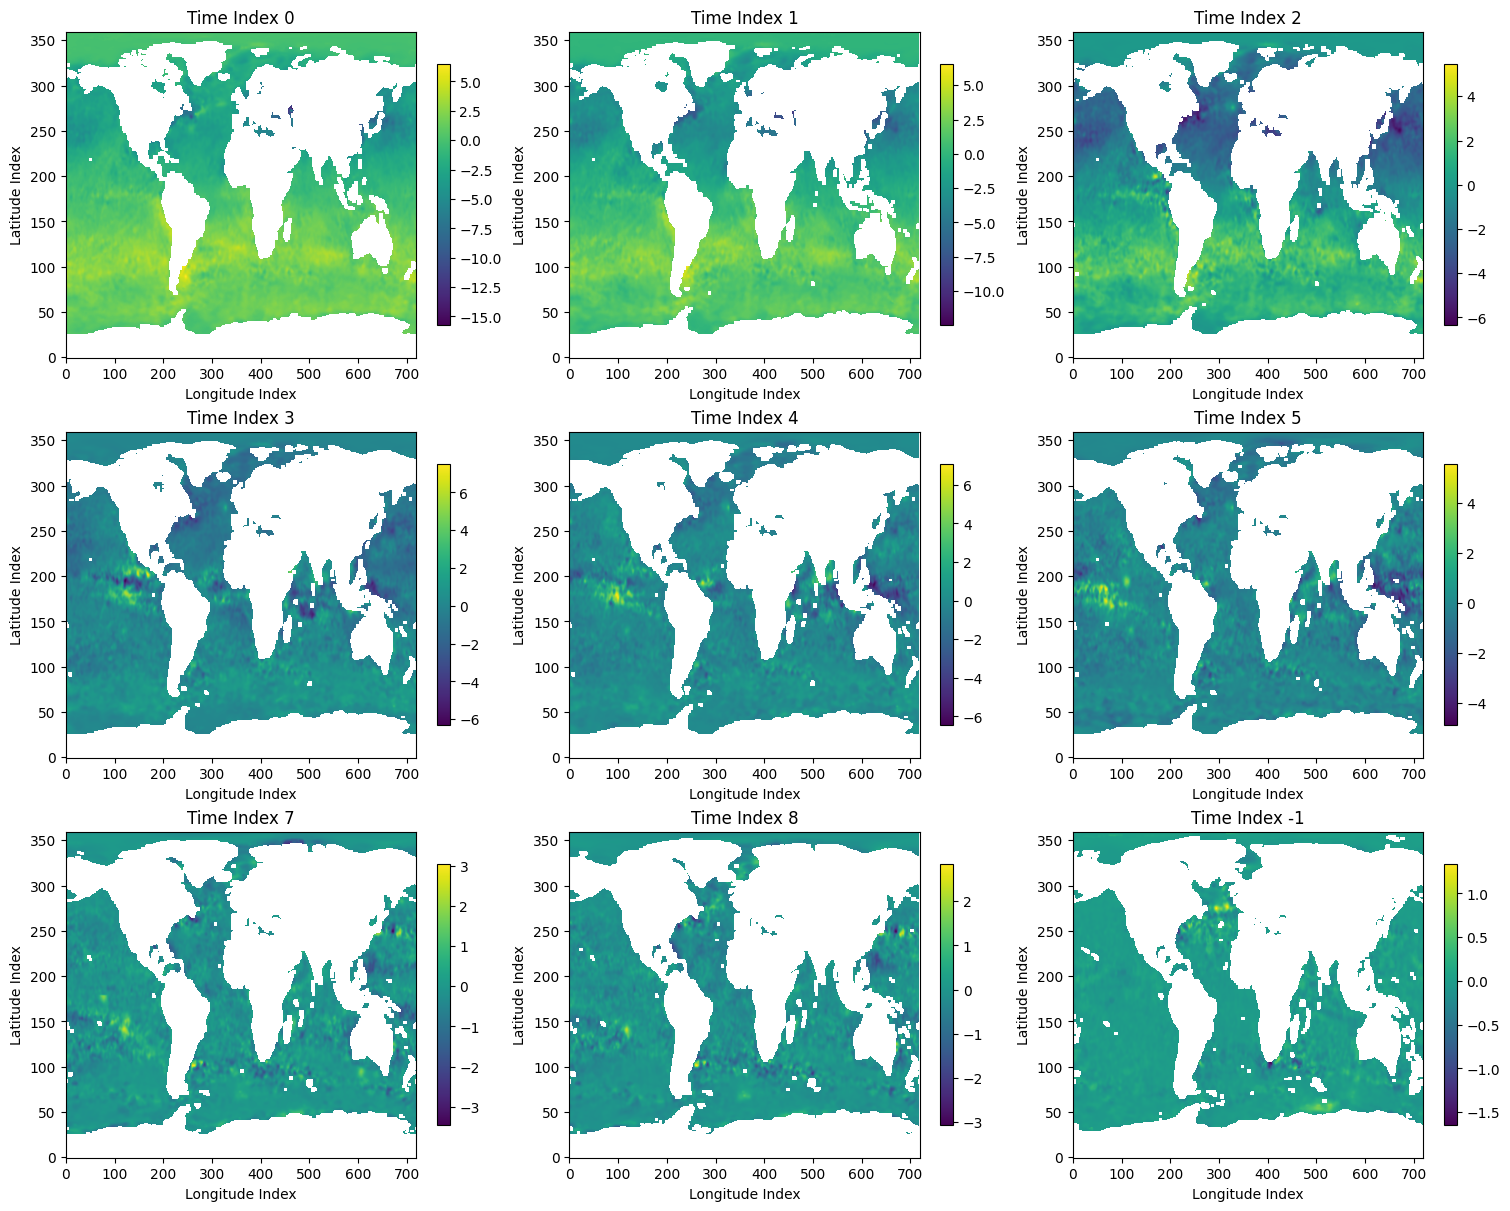

In [60]:
plot_multiple_ocean_data(st[0, ...], [0, 1, 2, 3, 4, 5, 7, 8, -1])

in sub:  (313, 15, 360, 720) (360,) (720,)


(313, 15, 54, 100)
in sub:  (313, 15, 360, 720) (360,) (720,)
(313, 15, 54, 100)
(313, 15, 54, 100) (313, 15, 54, 100)


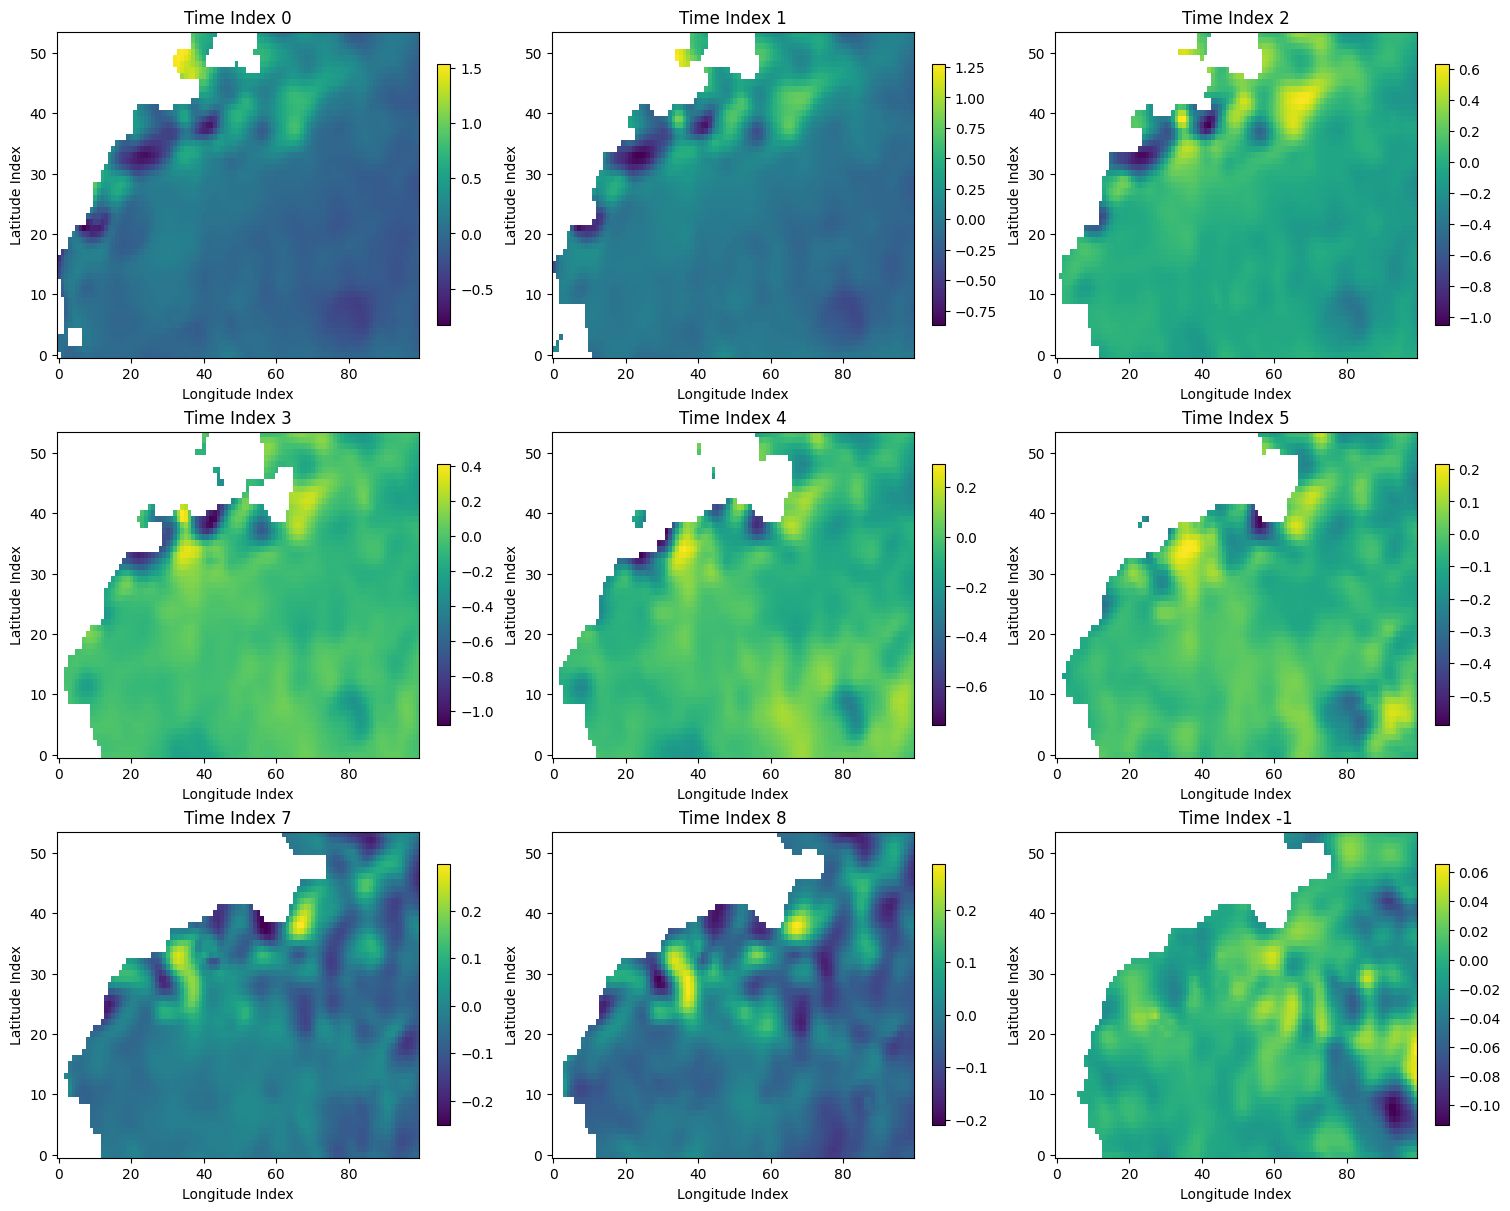

In [61]:
def get_sub(data, latitude, longitude):
        """
        提取子区域的数据

        input:
        lat_min, lat_max, lon_min, lon_max: 子区域范围
        data: 原始数据
        latitude, longitude: 经纬度数据

        return: subset_data, subset_lat, subset_lon
        """
        lat_min, lat_max = 23, 50
        lon_min, lon_max = -80, -30
        # 找到对应的索引
        print('in sub: ', data.shape, latitude.shape, longitude.shape)
        lat_indices = np.where((latitude >= lat_min) & (latitude <= lat_max))[0]
        lon_indices = np.where((longitude >= lon_min) & (longitude <= lon_max))[0]
        # 提取子集数据
        subset_data = data[:, :, lat_indices, :][:, :, :, lon_indices]
        print(subset_data.shape)
        # 提取相应的经纬度数组
        subset_lat = latitude[lat_indices]
        subset_lon = longitude[lon_indices]

        return subset_data, subset_lat, subset_lon

ss_gulf,_, _ = get_sub(ss, lat, lon)
st_gulf, _, _ = get_sub(st, lat, lon)
print(ss_gulf.shape, st_gulf.shape)

plot_multiple_ocean_data(ss_gulf[0, ...], [0, 1, 2, 3, 4, 5, 7, 8, -1])

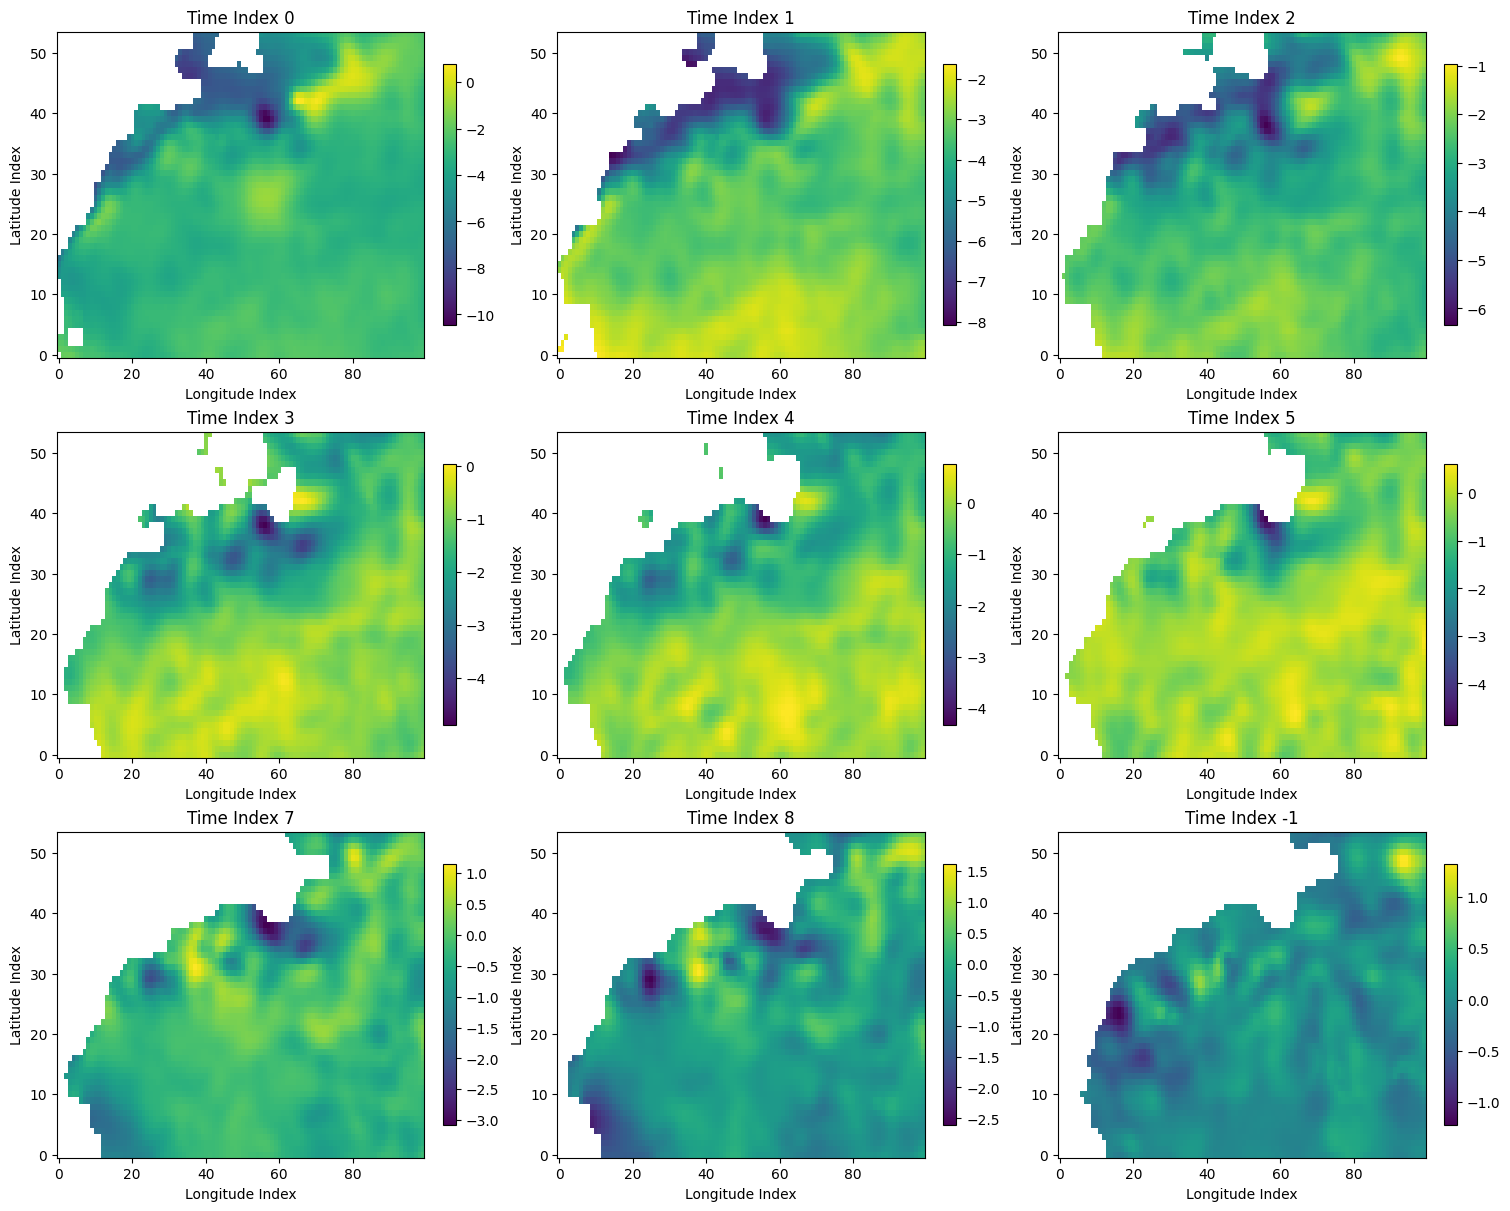

In [62]:
plot_multiple_ocean_data(st_gulf[0, ...], [0, 1, 2, 3, 4, 5, 7, 8, -1])

原数据集：

shape of variable:  torch.Size([99, 12, 54, 100]) torch.Size([99, 36, 54, 100]) torch.Size([54]) torch.Size([100]) torch.Size([36])
torch.Size([5, 12, 54, 100])
torch.Size([5, 36, 54, 100])
torch.Size([5, 54, 100])
torch.Size([5, 54])
torch.Size([5, 100])

shape of variable:  torch.Size([94, 5, 12, 54, 100]) torch.Size([94, 1, 36, 54, 100]) torch.Size([54]) torch.Size([100]) torch.Size([36])
torch.Size([5, 5, 12, 54, 100])
torch.Size([5, 1, 36, 54, 100])
torch.Size([5, 54, 100])
torch.Size([5, 54])
torch.Size([5, 100])



新数据集：

Shape of variables: torch.Size([288, 6, 54, 100]) torch.Size([288, 15, 54, 100]) torch.Size([54]) torch.Size([100]) torch.Size([15])
torch.Size([16, 6, 54, 100])
torch.Size([16, 15, 54, 100])
torch.Size([16, 54, 100])
torch.Size([16, 54])
torch.Size([16, 100])

Shape of variable: torch.Size([283, 5, 6, 360, 720]) torch.Size([283, 1, 15, 360, 720]) torch.Size([360]) torch.Size([720]) torch.Size([15])
torch.Size([16, 5, 6, 360, 720])
torch.Size([16, 1, 15, 360, 720])
torch.Size([16, 360, 720])
torch.Size([16, 360])
torch.Size([16, 720])
torch.Size([16, 15])

In [63]:
import h5py
import numpy as np
import os
import torch
from torch.utils.data import Dataset
import xarray as xr
from netCDF4 import Dataset as dataset_net
import sys
sys.path.append('../')
from dataset import STDataset

# 选择子区域
# 归一化与逆归一化


In [64]:
from torch.utils.data import DataLoader
regin_name = 'Gulf'


dataset  = STDataset(region_name=regin_name, task = 'T', if_train=False, seq_len=0)

test_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)
data = list(test_loader)[-1]
print(len(data))
for i in range(len(data)):
    print(data[i].shape)

input = data[0]
label = data[1]
print(input.shape, label.shape)

Shape of variables: torch.Size([25, 10, 54, 100]) torch.Size([25, 15, 54, 100]) torch.Size([54]) torch.Size([100]) torch.Size([15])
5
torch.Size([1, 10, 54, 100])
torch.Size([1, 15, 54, 100])
torch.Size([1, 54, 100])
torch.Size([1, 54])
torch.Size([1, 100])
torch.Size([1, 10, 54, 100]) torch.Size([1, 15, 54, 100])


In [65]:

input_0 = data[0][0]

for i in range(input_0.shape[0]):
    x = input_0[i]
    
    # 查看NaN的数量
    nan_count = torch.isnan(x).sum().item()
    print(f"Variable {i} has {nan_count} NaN values.")
    
    # 排除NaN后的最大最小值
    valid_x = x[~torch.isnan(x)]
    max_value = valid_x.max().item() if valid_x.numel() > 0 else float('nan')
    min_value = valid_x.min().item() if valid_x.numel() > 0 else float('nan')
    print(f"Variable {i} - Max (excluding NaN): {max_value}, Min (excluding NaN): {min_value}")


Variable 0 has 784 NaN values.
Variable 0 - Max (excluding NaN): 0.982237696647644, Min (excluding NaN): -0.5360267162322998
Variable 1 has 646 NaN values.
Variable 1 - Max (excluding NaN): 0.7930203080177307, Min (excluding NaN): 0.23534460365772247
Variable 2 has 703 NaN values.
Variable 2 - Max (excluding NaN): 0.8144431114196777, Min (excluding NaN): 0.25999194383621216
Variable 3 has 0 NaN values.
Variable 3 - Max (excluding NaN): 0.6169670224189758, Min (excluding NaN): 0.376921683549881
Variable 4 has 773 NaN values.
Variable 4 - Max (excluding NaN): 0.9319406747817993, Min (excluding NaN): 0.7266086339950562
Variable 5 has 0 NaN values.
Variable 5 - Max (excluding NaN): 0.597847044467926, Min (excluding NaN): 0.32506465911865234
Variable 6 has 0 NaN values.
Variable 6 - Max (excluding NaN): 1.0, Min (excluding NaN): 0.0
Variable 7 has 0 NaN values.
Variable 7 - Max (excluding NaN): 1.0, Min (excluding NaN): 0.0
Variable 8 has 0 NaN values.
Variable 8 - Max (excluding NaN): 0.54

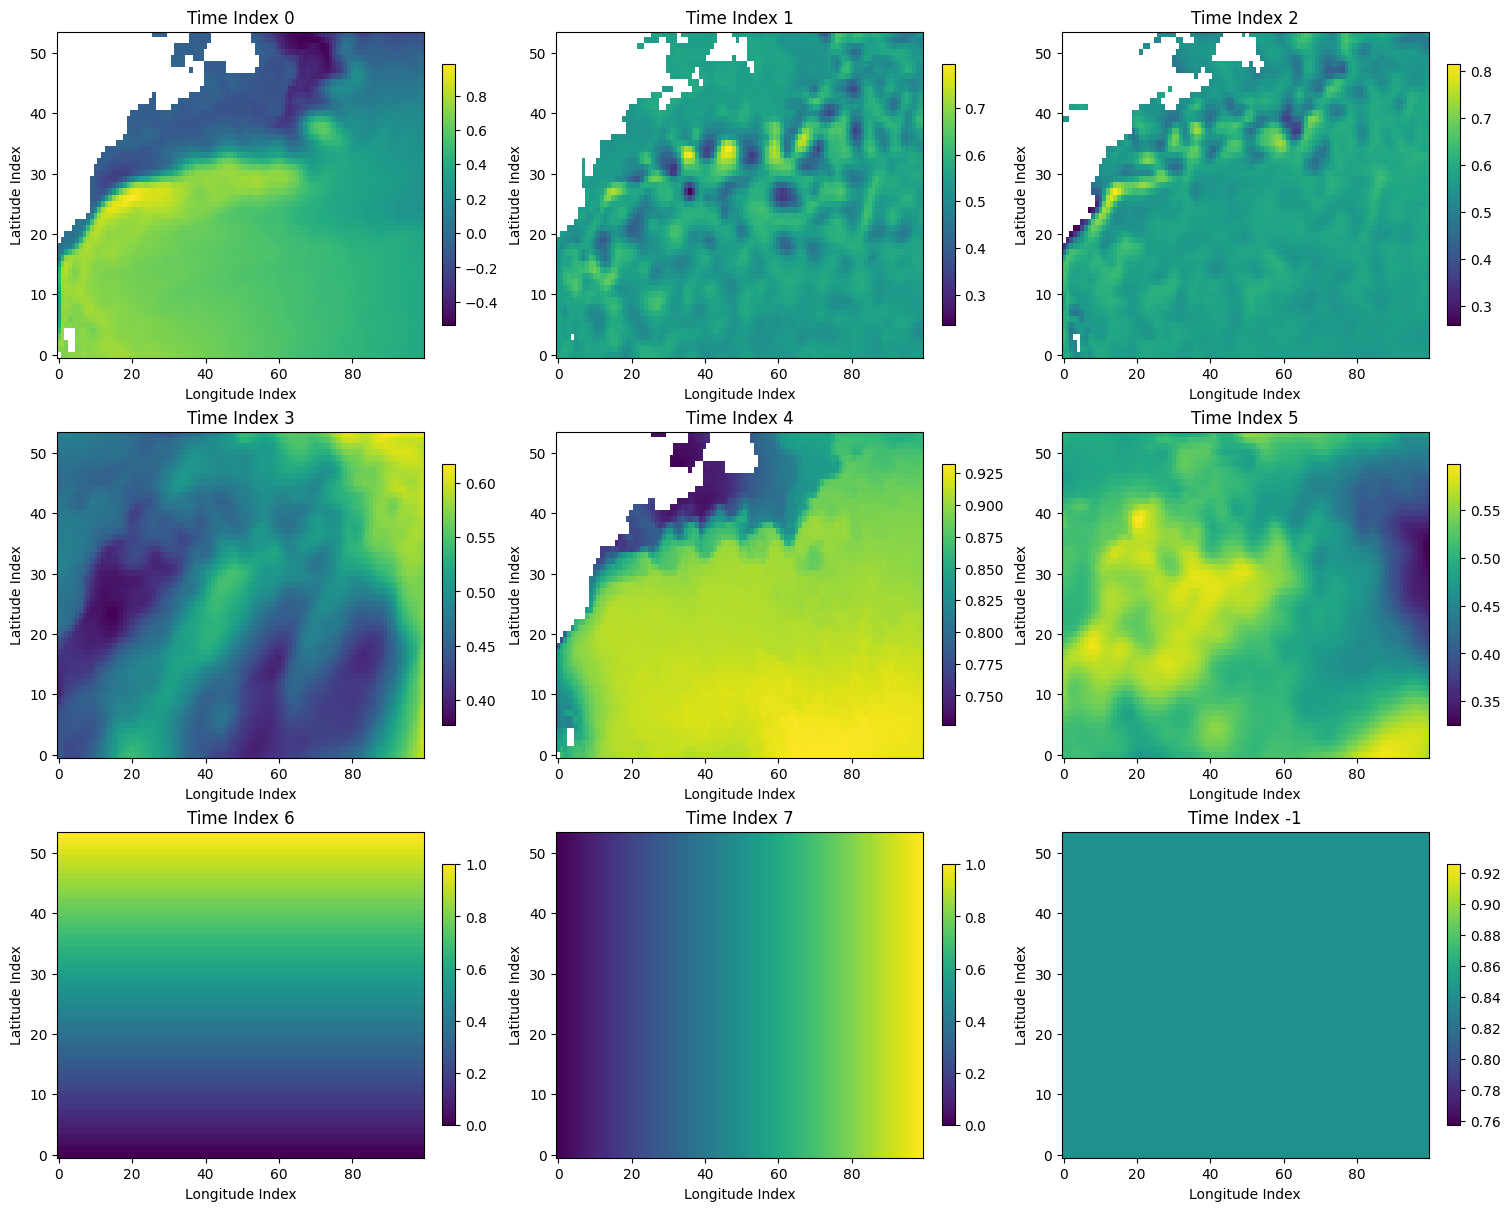

In [66]:
# 查看input的图像
plot_multiple_ocean_data(input[0, ...], [0, 1, 2, 3, 4, 5, 6, 7, -1])

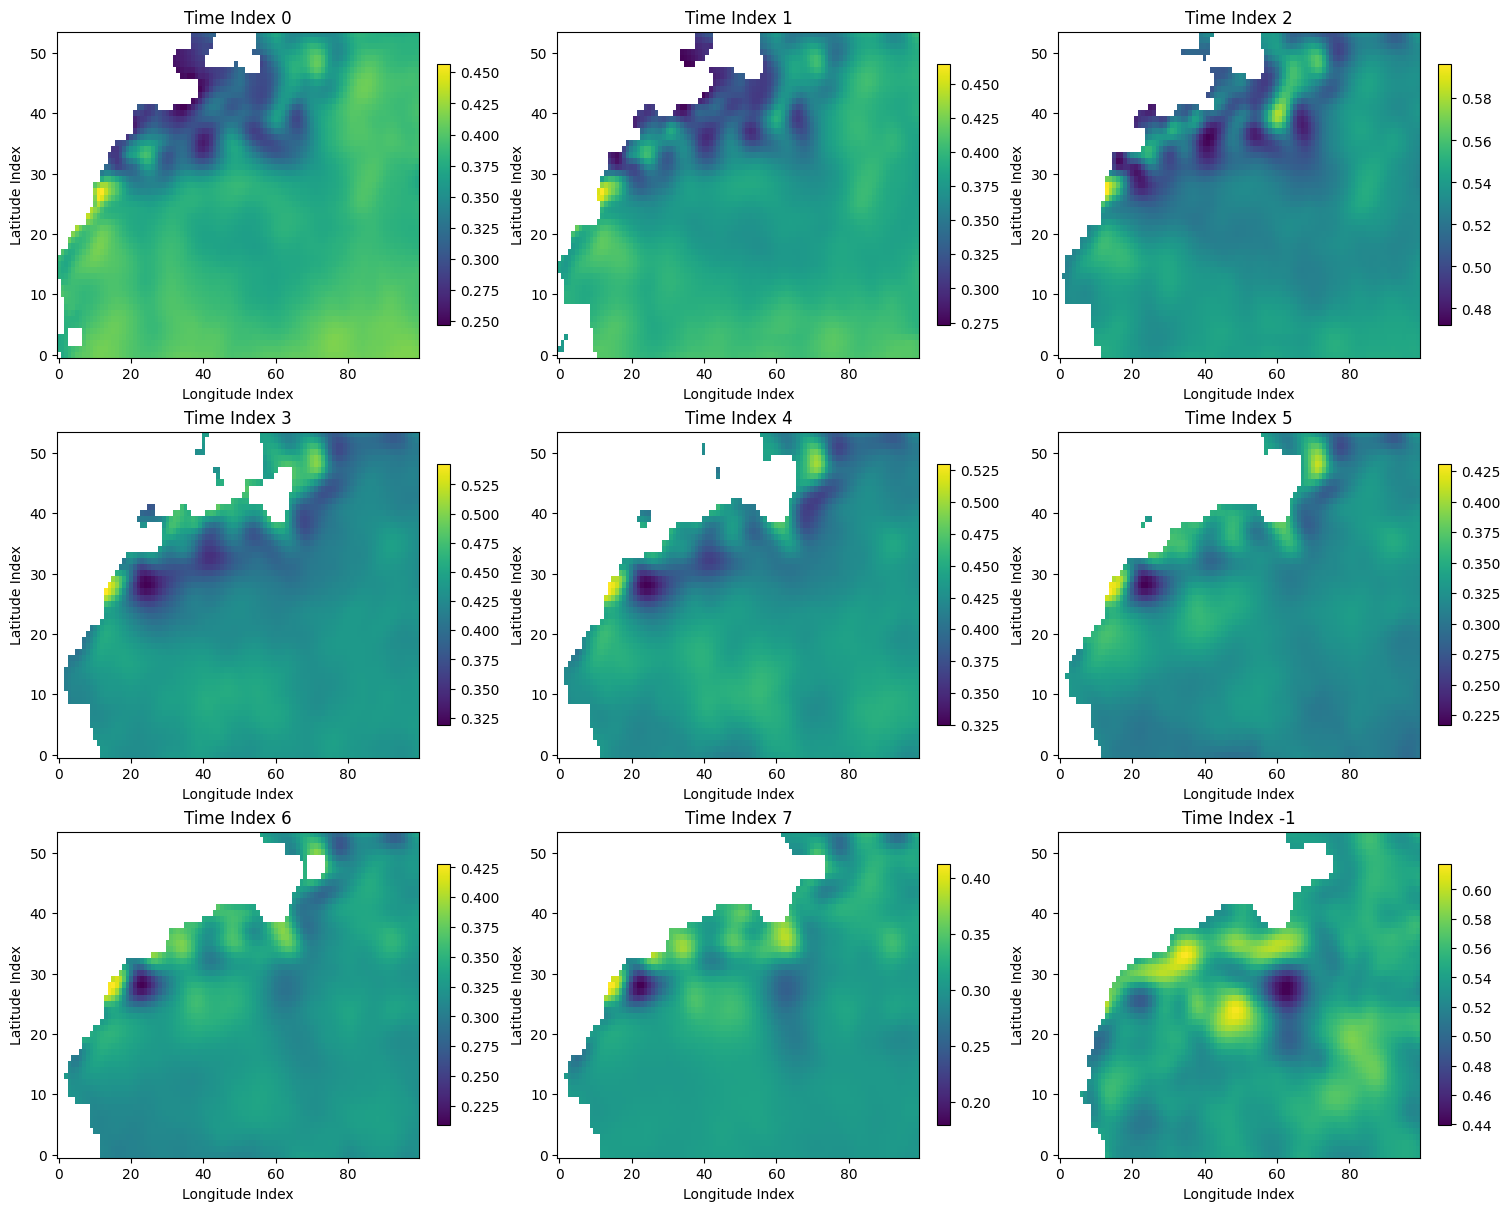

In [67]:
# 查看label的图像
plot_multiple_ocean_data(label[0, ...], [0, 1, 2, 3, 4, 5, 6, 7, -1])

torch.Size([1, 10, 54, 100]) torch.Size([1, 15, 54, 100]) torch.Size([1, 54, 100])


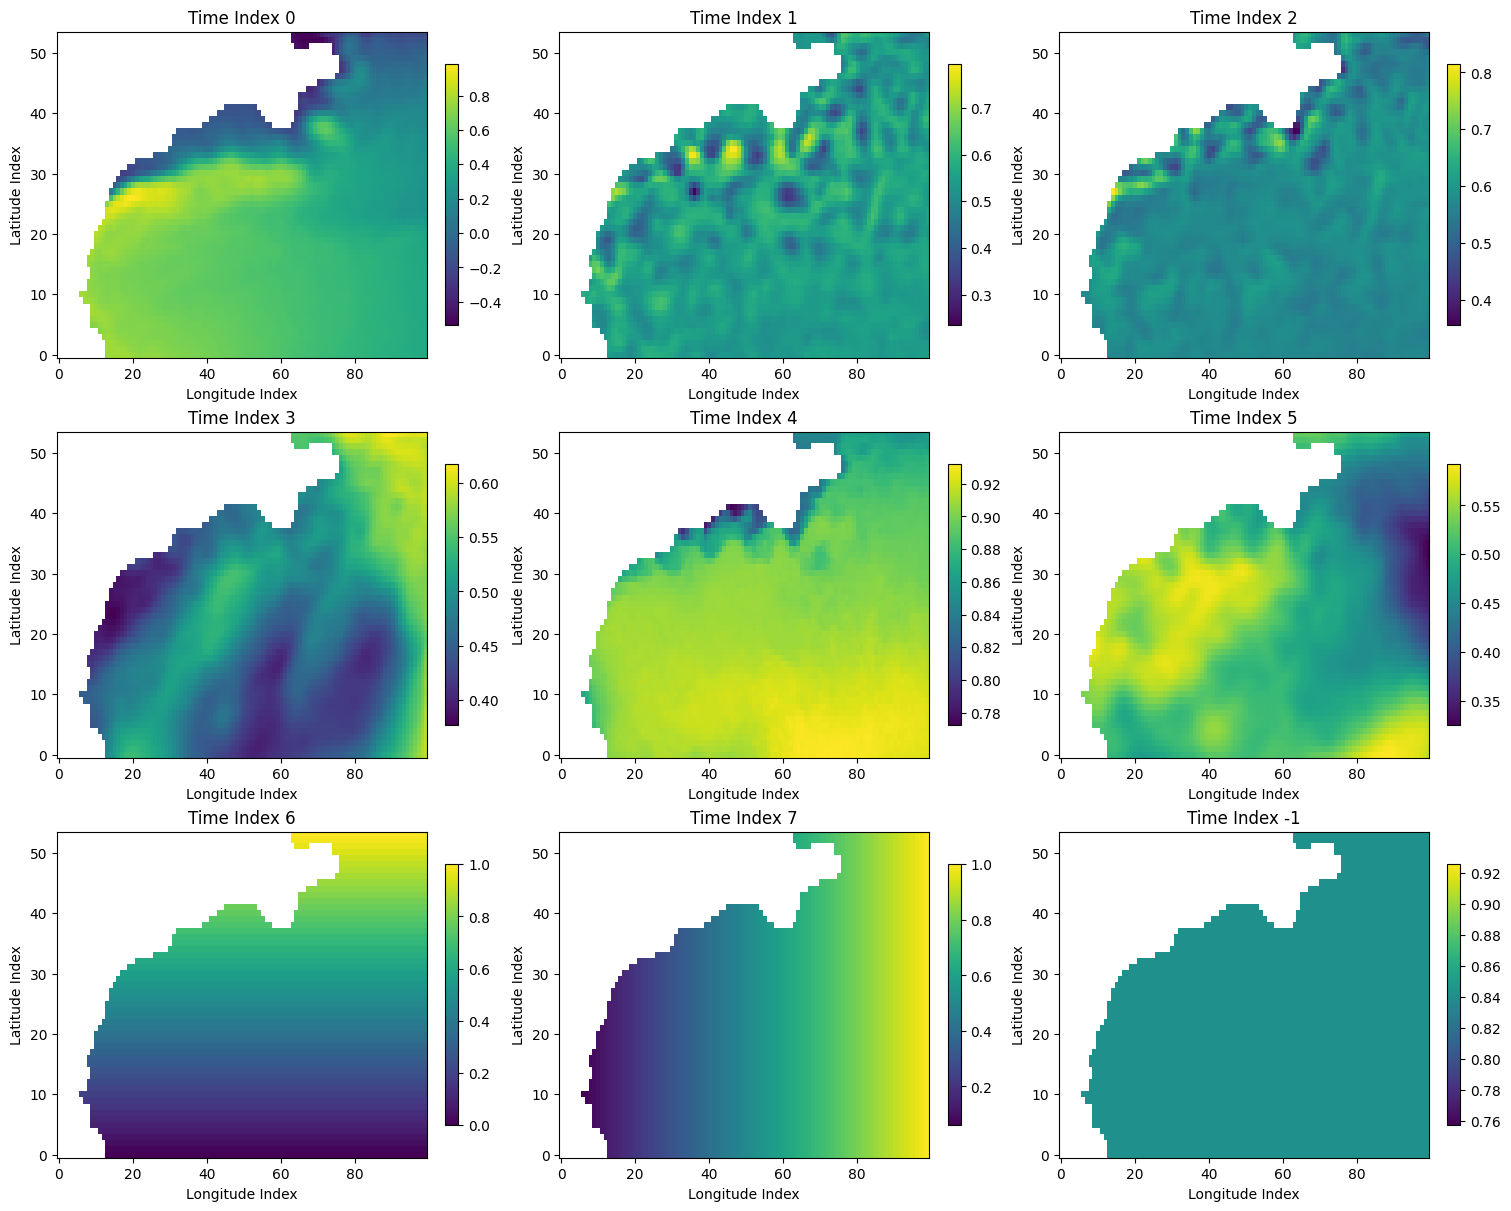

In [68]:
# 查看掩码后input的值
x = data[0]
y = data[1]
mask = data[2]
print(x.shape, y.shape, mask.shape)

mask_x = mask.unsqueeze(1).repeat(1 ,x.shape[1], 1, 1)
x = torch.where(mask_x, x, torch.nan)

plot_multiple_ocean_data(x[0, ...], [0, 1, 2, 3, 4, 5, 6, 7, -1])

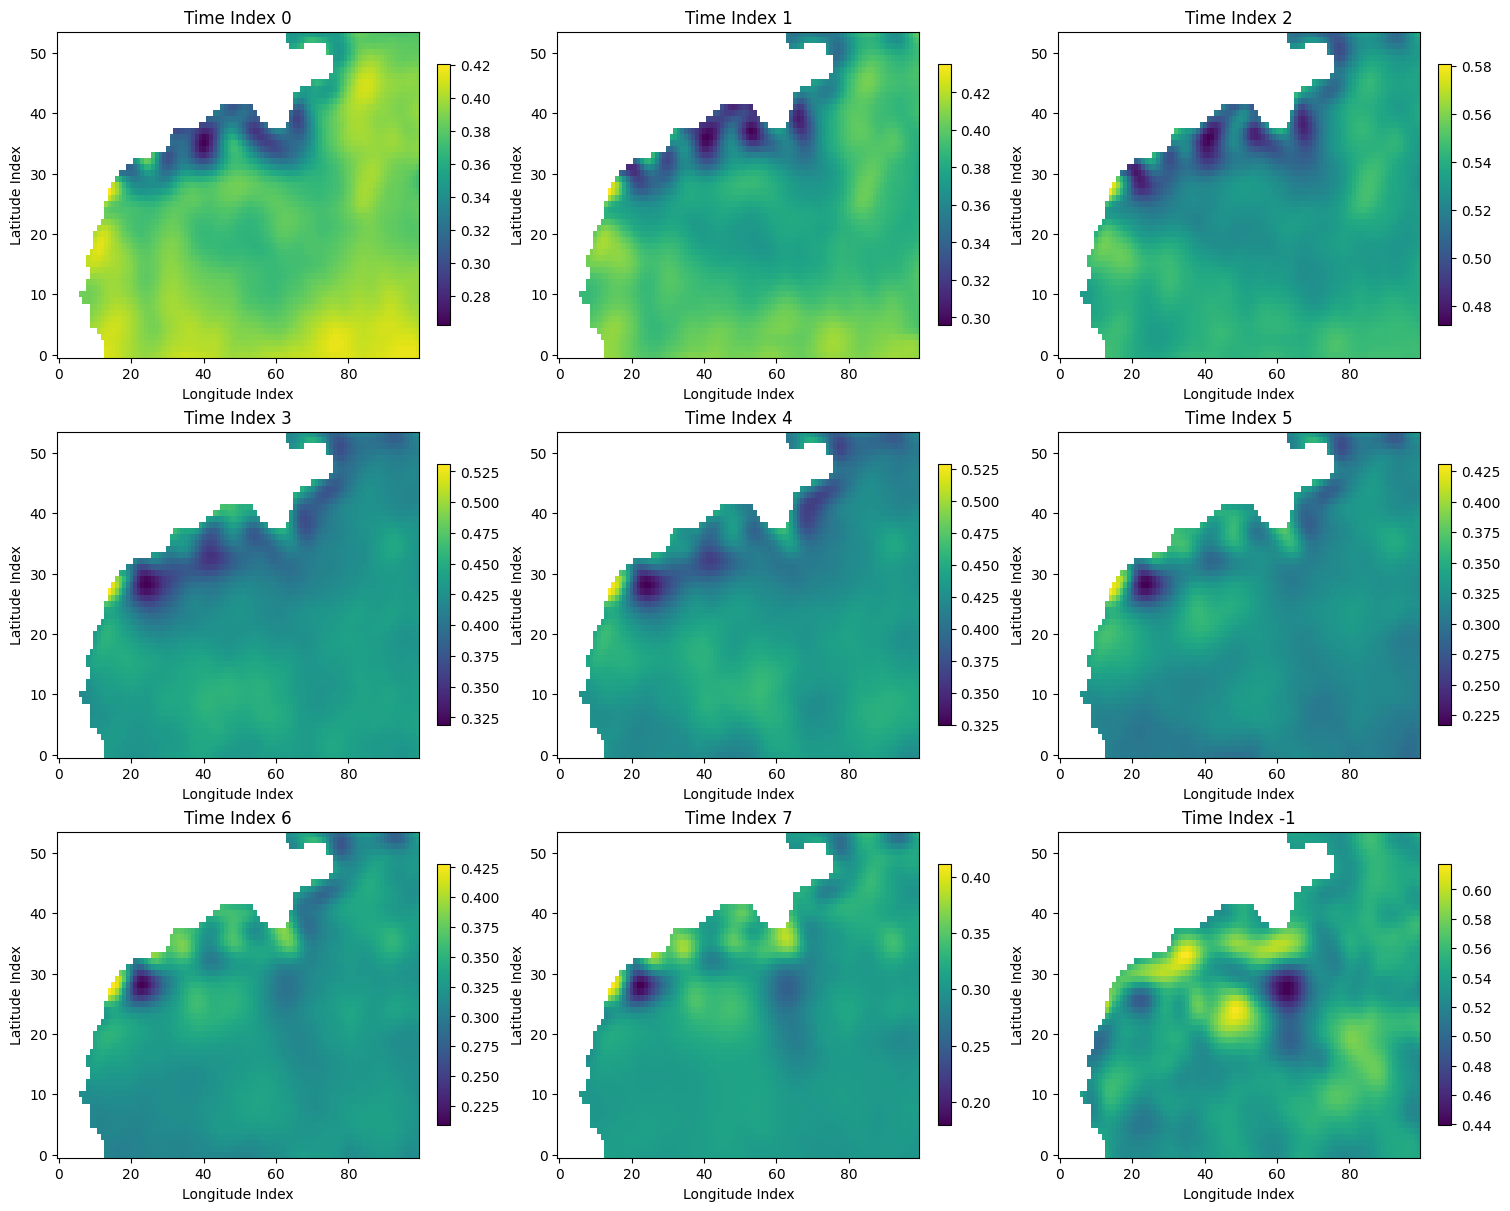

In [69]:
# 掩码后label的值
mask_y = mask.unsqueeze(1).repeat(1 ,y.shape[1], 1, 1) # (1, lat, lon) --> (bs, depth, lat, lon)
y = torch.where(mask_y, y, torch.nan)

plot_multiple_ocean_data(y[0, ...], [0, 1, 2, 3, 4, 5, 6, 7, -1])

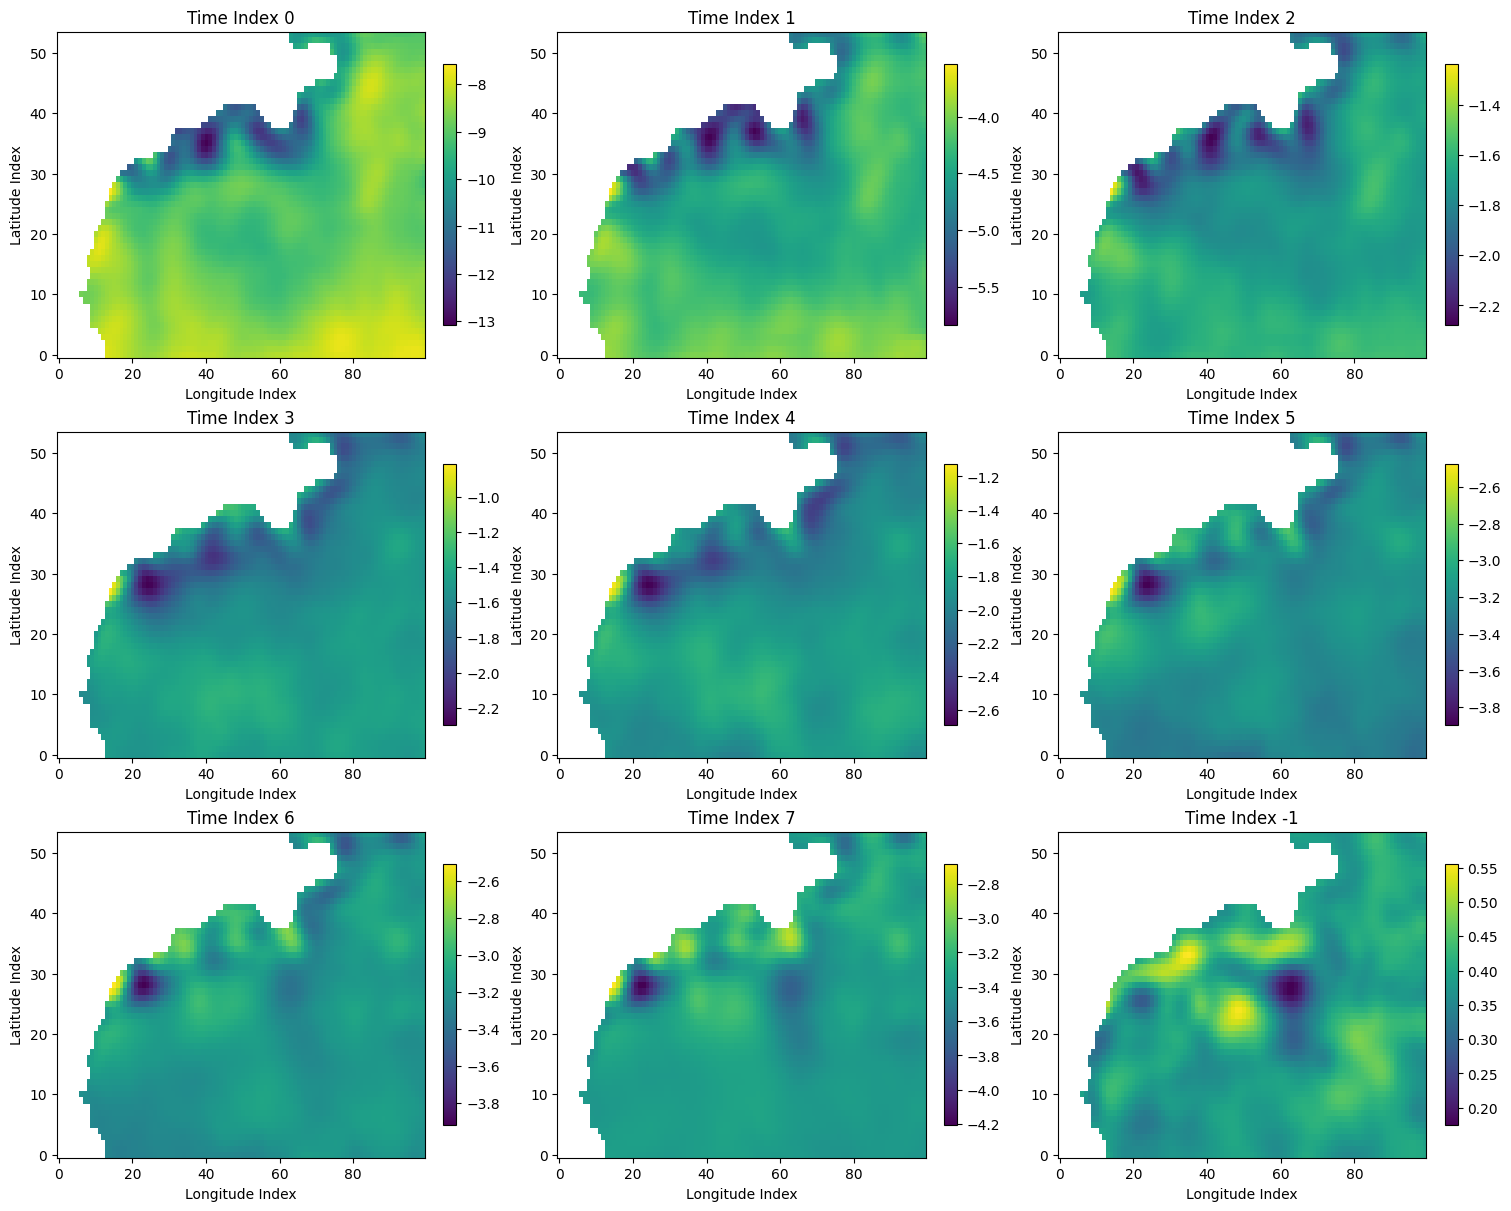

In [70]:
# y 逆归一化的值
label_min = torch.tensor([-22.1688, -10.7299,  -6.7963,  -4.5278,  -5.1864,  -5.3361,  -5.2669,
        -5.3840,  -5.5155,  -5.6514,  -5.7799,  -5.7644,  -0.9412,  -0.7708,
        -0.7653])
label_max = torch.tensor([12.5135,  5.7999,  2.7736,  2.4664,  2.4894,  1.3013,  1.1822,  1.1807,
        1.5135,  1.5618,  1.5975,  1.5667,  1.5419,  1.4785,  1.3738])
label_min = label_min.view(-1, 1, 1).to(y.dtype)
label_max = label_max.view(-1, 1, 1).to(y.dtype)
y_minmax = y * (label_max - label_min) + label_min

plot_multiple_ocean_data(y_minmax[0, ...], [0, 1, 2, 3, 4, 5, 6, 7, -1])

## other dataset

In [108]:
import h5py
import numpy as np
import os
import torch
from torch.utils.data import Dataset
import xarray as xr
from netCDF4 import Dataset as dataset_net

# 选择子区域
# 归一化与逆归一化

class STDataset_points(Dataset):
    def __init__(self,
                 region_name = 'Gulf',
                 folder_path='/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/',
                 label_path='/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/label.nc',
                 task='S',  # S T Chl 
                 if_train=True,
                 seq_len=5,
                 ):

        if region_name == 'Gulf':
            self.lat_min, self.lat_max = 23, 50
            self.lon_min, self.lon_max = -80, -30
        elif region_name == 'Pacific':
            self.lat_min, self.lat_max = -30, 50  
            self.lon_min, self.lon_max = -110, 140  
        elif region_name == 'Indian':
            self.lat_min, self.lat_max = -35, 30  
            self.lon_min, self.lon_max = 25, 120  

        else: 
            print('Invilid regian name!!!')
        key = task
        self.input, self.label, self.lat, self.lon, self.depth, self.minmax = self.get_data(folder_path, key)

        self.input = torch.tensor(self.input).permute(1, 0, 2, 3)  # [time, var, lat, lon]
        self.label = torch.tensor(self.label).permute(1, 0, 2, 3)  # [time, depth, lat, lon]
        self.lat = torch.tensor(self.lat)
        self.lon = torch.tensor(self.lon)
        self.depth = torch.tensor(self.depth)

        # 将lat和lon合并到input中
        time = self.input.shape[0]
        lat = self.input.shape[2]
        lon = self.input.shape[3]
        expand_lat = self.lat.unsqueeze(0).unsqueeze(-1).repeat(time, 1, 1, lon)
        expand_lon = self.lon.unsqueeze(0).unsqueeze(0).repeat(time, 1, lat, 1)
        self.input = torch.cat((self.input, expand_lat, expand_lon), dim=1)
        print('add lat: ', self.input.shape, expand_lat.shape)

        # 将时间合并到input中
        time_series = np.array(range(time))
        jd1 = torch.cos( torch.tensor(2*np.pi*(time_series/12)+1) )
        jd2 = torch.sin( torch.tensor(2*np.pi*(time_series/12)+1) )
        jd1 = jd1.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).repeat(1, 1, lat, lon)
        jd2 = jd2.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).repeat(1, 1, lat, lon)
        print('add time: ', self.input.shape, jd1.shape)
        # print('jd1, jd2', jd1.shape, jd2.shape)
        self.input = torch.cat((self.input, jd1), dim=1)
        self.input = torch.cat((self.input, jd2), dim=1)

        # Create mask: if any input variable or label at a grid point is NaN, set mask to False
        input_nan_mask = torch.isnan(self.input)
        label_nan_mask = torch.isnan(self.label)
        input_nan_mask = input_nan_mask.any(dim=(0, 1))  # [time, var, lat, lon]
        label_nan_mask = label_nan_mask.any(dim=(0, 1))
        self.mask = (~label_nan_mask) & (~input_nan_mask)  # [lat, lon], NaN

        # Time-series data: Add seq_len dimension, create sliding window sequences
        if seq_len > 0:
            num = self.input.shape[0] - seq_len
            self.input = torch.stack([self.input[i:i + seq_len] for i in range(num)], dim=0)
            self.label = torch.stack([self.label[i + seq_len - 1:i + seq_len] for i in range(num)], dim=0)

        # Split data into train: 199401-201712, test: 199301-199312, 201801-201901
        test_len = 12
        train_len = self.input.shape[0] - test_len
        if if_train:
            self.input = self.input[test_len + 1:train_len, ...]
            self.label = self.label[test_len + 1:train_len, ...]
        else:
            input1 = self.input[:test_len + 1, ...]  # First 12 months
            label1 = self.label[:test_len + 1, ...]
            input2 = self.input[train_len:, ...]  # Last 12 months
            label2 = self.label[train_len:, ...]
            self.input = torch.cat((input1, input2), dim=0)
            self.label = torch.cat((label1, label2), dim=0)

        print('Shape of variables:', self.input.shape, self.label.shape, self.lat.shape, self.lon.shape, self.depth.shape)

        self.input = self.input.permute(0,2,3,1).reshape(-1, self.input.shape[1])
        self.label = self.label.permute(0,2,3,1).reshape(-1, self.label.shape[1])

        print('shape of variable: ', self.input.shape, self.label.shape, self.lat.shape, self.lon.shape, self.depth.shape)


    def get_data(self, folder_path, key):
        """
        Extract input data and concatenate
        folder_path: data folder path

        return: (var, time, lat, lon)
        """
        input_path = os.path.join(folder_path, 'input.nc')
        label_path = os.path.join(folder_path, 'label.nc')
        input = xr.open_dataset(input_path)
        label = xr.open_dataset(label_path)
        
        # 归一化input
        input_data = torch.tensor(input['data'].values)
        
        masked_input = input_data.clone()
        masked_input[torch.isnan(masked_input)] = -float('inf')  # 将 NaN 替换为无穷小以忽略它们
        max_input, _ = torch.max(masked_input.view(masked_input.shape[0], -1), dim=1)
        masked_input[torch.isnan(input_data)] = float('inf')  # 将 NaN 替换为无穷大以忽略它们
        min_input, _ = torch.min(masked_input.view(masked_input.shape[0], -1), dim=1)
        max_input[0], min_input[0] = 1, 0  # 第一个为mdt数据，不归一化

        max_input, min_input = max_input.view(max_input.shape[0], 1, 1, 1).expand_as(input_data), min_input.view(max_input.shape[0], 1, 1, 1).expand_as(input_data)
        input_minmax = (input_data - min_input) / (max_input - min_input) 

        # 归一化label
        label_data = torch.tensor(label[key].values).permute(1, 0, 2, 3)

        masked_label = label_data.clone()
        masked_label[torch.isnan(masked_label)] = -float('inf')
        max_label, _ = torch.max(masked_label.reshape(masked_label.shape[0], -1), dim=1)
        masked_label[torch.isnan(label_data)] = float('inf')
        min_label, _ = torch.min(masked_label.reshape(masked_label.shape[0], -1), dim=1)

        max_label, min_label = max_label.view(label_data.shape[0], 1, 1, 1).expand_as(label_data), min_label.view(label_data.shape[0], 1, 1, 1).expand_as(label_data)
        label_minmax = (label_data - min_label) / (max_label - min_label) 

        # 存储最值
        minmax = [min_input, max_input, min_label, max_label]

        # get sub
        
        input_sub, lat_sub, lon_sub = self.get_sub(input_minmax, input['lat'].values, input['lon'].values)
        label_sub, _, _ = self.get_sub(label_minmax, input['lat'].values, input['lon'].values)

        return input_sub, label_sub, lat_sub, lon_sub, label['depth'].values, minmax
    
    def get_sub(self, data, latitude, longitude):
        """
        提取子区域的数据

        input:
        lat_min, lat_max, lon_min, lon_max: 子区域范围
        data: 原始数据
        latitude, longitude: 经纬度数据

        return: subset_data, subset_lat, subset_lon
        """
        # 找到对应的索引
        print('in sub: ', data.shape, latitude.shape, longitude.shape)
        lat_indices = np.where((latitude >= self.lat_min) & (latitude <= self.lat_max))[0]
        lon_indices = np.where((longitude >= self.lon_min) & (longitude <= self.lon_max))[0]
        # 提取子集数据
        subset_data = data[:, :, lat_indices, :][:, :, :, lon_indices]
        print(subset_data.shape)
        # 提取相应的经纬度数组
        subset_lat = latitude[lat_indices]
        subset_lon = longitude[lon_indices]

        return subset_data, subset_lat, subset_lon

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        inputs = self.input[idx]   # (var, lat, lon) or (seq, var, lat, lon)
        label = self.label[idx]    # (dept, lat, lon) or (seq, dept, lat, lon)
        lat = self.lat
        lon = self.lon
        depth = self.depth
        mask = self.mask  # (lat, lon)
        
        return inputs.float(), label.float(), mask, lat, lon



In [109]:
from torch.utils.data import DataLoader

dataset  = STDataset_points(task = 'T', seq_len=0)

train_loader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=0)
data = next(iter(train_loader))
print(len(data))
for i in range(len(data)):
    print(data[i].shape)

in sub:  torch.Size([6, 313, 360, 720]) (360,) (720,)
torch.Size([6, 313, 54, 100])
in sub:  torch.Size([15, 313, 360, 720]) (360,) (720,)
torch.Size([15, 313, 54, 100])
add lat:  torch.Size([313, 8, 54, 100]) torch.Size([313, 1, 54, 100])
add time:  torch.Size([313, 8, 54, 100]) torch.Size([313, 1, 54, 100])
Shape of variables: torch.Size([288, 10, 54, 100]) torch.Size([288, 15, 54, 100]) torch.Size([54]) torch.Size([100]) torch.Size([15])
shape of variable:  torch.Size([1555200, 10]) torch.Size([1555200, 15]) torch.Size([54]) torch.Size([100]) torch.Size([15])
5
torch.Size([16, 10])
torch.Size([16, 15])
torch.Size([16, 54, 100])
torch.Size([16, 54])
torch.Size([16, 100])


/tmp/ipykernel_967884/1170113489.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.input = torch.tensor(self.input).permute(1, 0, 2, 3)  # [time, var, lat, lon]
/tmp/ipykernel_967884/1170113489.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.label = torch.tensor(self.label).permute(1, 0, 2, 3)  # [time, depth, lat, lon]


In [20]:
# 将所有的文件合并在var维度
def get_input_data(folder_path):
    """
    提取输入数据并拼接
    folder_path: 数据文件夹地址
    
    return:  (var, time, lat, lon)
    """
    # 1、提取文件名
    nc_files = [file for file in os.listdir(folder_path) if file.endswith('.nc')]
    # 存储数据
    data_all = []
    # 2、逐个加载.nc文件
    for file in nc_files:
        file_path = os.path.join(folder_path, file)
        print(f"Processing file: {file_path}")
        ds = xr.open_dataset(file_path)
        # 提取目标子区域
        subset_data = ds.sel(lat=slice(23, 50), lon=slice(-80, -30)) 
        data_all.append(subset_data)

    # 将所有插值后的数据堆叠在一起
    data_all = xr.concat(data_all, dim='var')
    data_all = data_all.where(np.abs(data_all) <= 100, np.nan)  # 将数据中绝对值大于100的数值替换为NaN

    # print('shape of region:', data_all.shape)
    return data_all['data']

path = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/'
data = get_input_data(path)
print(data['data'].values.shape)

Processing file: /home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/u_199301_201901_monthly_1.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/v_199301_201901_monthly_1.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/sla_199301_201901_monthly.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/sos_l4_199301_201901_monthly_1.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/mdt_cnes_cls18_global_1.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/oisst_199301_201901_monthly_1.nc
(6, 313, 27, 50)


In [23]:

def min_max(data):
    """
    对输入数据按变量进行归一化

    input: (var, time, lat, lon) xr.dataset
    output: (var, time, lat, lon)
    """
    if isinstance(data, xr.Dataset):
        minmax = data.apply(lambda x: (x - x.min(dim='time')) / (x.max(dim='time') - x.min(dim='time')))
    elif isinstance(data, xr.DataArray):
        minmax = (data - data.min(dim='time')) / (data.max(dim='time') - data.min(dim='time'))
    else:
        raise ValueError("Input data must be an xarray Dataset or DataArray.")
    
    return minmax

min_max_data = min_max(data)
print(min_max_data['data'].values.shape)

(6, 313, 27, 50)


In [4]:
path = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/label/CORA_ST.nc'
ds = xr.open_dataset(path)
print(ds)

SS = ds['TEMP'].values
print(SS.shape)

<xarray.Dataset>
Dimensions:    (time: 313, depth: 102, latitude: 180, longitude: 360)
Coordinates:
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * depth      (depth) float32 1.0 3.0 5.0 10.0 15.0 ... 940.0 960.0 980.0 1e+03
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-01-01
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    TEMP       (time, depth, latitude, longitude) float64 ...
(313, 102, 180, 360)


In [31]:
import h5py
import numpy as np
import os
import torch
from torch.utils.data import Dataset, IterableDataset
import xarray as xr
import torch.nn.functional as F
from netCDF4 import Dataset as dataset_net
from sklearn.preprocessing import MinMaxScaler

# 数据归一化问题
# 输入数据处理：基于reference_file插值

class STDataset_1993_2019(Dataset):
    def __init__(self,
                 region_name = 'Gulf',
                 folder_path='/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/',
                 reference_file = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/oisst_199301_201901_monthly_1.nc',
                 label_path = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/label/label.nc',
                 task = 'S',  # S T Chl 
                 add_time = True,
                 if_train = True,
                 seq_len = 0,
                 ):
        '''
        提取201001-201901的每月数据
        Args:
            region_name(str) : 提取的数据空间范围(Gulf )
            folder_path(str) : 存放所有数据的文件夹 , "/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data"
            task(str) : 任务(S T Chl 三个任务)
            key(str) : SS(so), ST(st)
        Returns:
            input, label, lat, lon, depth
        shape:
            (var, month, lat, lon), (depth, month, lat, lon), (x, y, p), (x, y, 2), (36)

            lat_min, lat_max, lon_min, lon_max, data, latitude, longitude
        '''
        if region_name == 'Gulf':
            self.lat_min = 23
            self.lat_max = 50
            self.lon_min = -80  # 80w
            self.lon_max = -30  # 30n
        else:
            self.lat_min = -89.5
            self.lat_max = 89.5
            self.lon_min = -179.5  # 80w
            self.lon_max = 179.5  # 30n

        if task == 'T':
            key = 'TEMP'
        elif task == 'S':
            key = 'PSAL'

        # 提取数据
        self.input, input_min, input_max = self.get_input_data(folder_path)
        self.label, self.lat, self.lon, self.depth, label_min, label_max = self.get_label(label_path, key)
        # self.mask = torch.where(self.mask, 0, 1)  # 将True False 换为0 1，false代表非nan值处
        
        self.input = torch.from_numpy(self.input.values).permute(1,0,2,3)
        self.label = torch.from_numpy(self.label.values).permute(0,1,2,3)
        self.lat = torch.from_numpy(self.lat.values)
        self.lon = torch.from_numpy(self.lon.values)
        self.depth = torch.from_numpy(self.depth.values)
        print('input: ', self.input.shape, 'label: ', self.label.shape)
        # print(self.lat.shape, self.lon.shape, self.depth.shape, self.mask.shape)

        # # 添加mdt
        # mdt_path = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/mdt/mdt_cnes_cls18_global_1.nc'
        # mdt_ds = xr.open_dataset(mdt_path)
        # print('before sel: ', mdt_ds['data'].values.shape, np.sum(np.isnan(mdt_ds['data'].values)))
        # sub_ds = mdt_ds.sel(lat=slice(self.lat_min, self.lat_max), lon=slice(self.lon_min, self.lon_max))
        # print('after sel: ', sub_ds['data'].values.shape, np.sum(np.isnan(sub_ds['data'].values)))
        # sub_ds = self.min_max(sub_ds)
        # print('after minmax: ', sub_ds['data'].values.shape, np.sum(np.isnan(sub_ds['data'].values)))
        # mdt = torch.tensor(sub_ds['data'].values).unsqueeze(1)
        # print('mdt: ', self.input.shape, mdt.shape)
        # self.input = torch.cat((self.input, mdt), dim=1)

        # 将lat和lon合并到input中
        time = self.input.shape[0]
        lat = self.input.shape[2]
        lon = self.input.shape[3]
        expand_lat = self.lat.unsqueeze(0).unsqueeze(-1).repeat(time, 1, 1, lon)
        expand_lon = self.lon.unsqueeze(0).unsqueeze(0).repeat(time, 1, lat, 1)
        self.input = torch.cat((self.input, expand_lat, expand_lon), dim=1)
        # print('after expand lat_lon: ', self.input.shape)

        # 将时间合并到input中
        if add_time:
            ds = xr.open_dataset(label_path)
            time = ds.variables['time'].values  # 199301 - 201901
            base_time = np.datetime64('1993-01-01', 'M')
            time_in_months = (time.astype('datetime64[M]') - base_time).astype('int64')  # 日期转换为int格式
            jd1 = torch.cos( torch.tensor(2*np.pi*(time_in_months/12)+1) )
            jd2 = torch.sin( torch.tensor(2*np.pi*(time_in_months/12)+1) )
            jd1 = jd1.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).repeat(1, 1, lat, lon)
            jd2 = jd2.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).repeat(1, 1, lat, lon)
            # print('jd1, jd2', jd1.shape, jd2.shape)
            self.input = torch.cat((self.input, jd1), dim=1)
            self.input = torch.cat((self.input, jd2), dim=1)
        # print('after expand time: ', self.input.shape)

        # 时间序列数据：增加seq_len维度，造滑动窗口序列
        if seq_len > 0:
            num = self.input.shape[0] - seq_len
            self.input = [ self.input[i:i+seq_len] for i in range(num) ]
            self.input = torch.stack(self.input, 0)  # torch.Size([num, seq, var, lat, lon])
            self.label = [ self.label[i+seq_len-1:i+seq_len] for i in range(num) ]
            self.label = torch.stack(self.label, 0)  # torch.Size([num, 1, var, lat, lon])，每个seq最后一个时刻的label
            # print('in seq-------------------------------------------------------')
            # print(self.input.shape, self.label.shape)
        
        # 创建掩码：若某个网格上有一个input变量或label为nan，该点掩码设置为true
        input_nan_mask = torch.isnan(self.input)  
        label_nan_mask = torch.isnan(self.label)
        print('mask: ', input_nan_mask.shape, label_nan_mask.shape)
        if seq_len > 0:
            input_nan_mask = input_nan_mask.any(dim=(0, 1, 2))  # [num, seq, var, lat, lon]
            label_nan_mask = label_nan_mask.any(dim=(0, 1, 2))
        else:
            input_nan_mask = input_nan_mask.any(dim=(0, 1))  # [num, var, lat, lon]
            label_nan_mask = label_nan_mask.any(dim=(0, 1))

        # 合并掩码，只有在 input 或 label 中有 NaN 时，该点掩码为 True
        mask = input_nan_mask & label_nan_mask  # [lat, lon]
        # 将 PyTorch 张量转换为 NumPy 数组
        mask_np = mask.numpy()

        # 计算 True 的数量
        true_count = np.sum(mask_np)
        # 计算 False 的数量
        false_count = np.prod(mask_np.shape) - true_count
        print(f"True 的数量: {true_count}")
        print(f"False 的数量: {false_count}")
        

        # 总数据：199301-201901
        # 数据划分为train:199401-201712 test:199301-199312, 201801-201901
        # 从train中随机拿出24个月份的数据作为验证集
        # test_len = 12
        # train_len = self.input.shape[0] - test_len
        # # print(train_len, test_len)
        # if if_train:
        #     self.input = self.input[test_len+1:train_len, ...]
        #     self.label = self.label[test_len+1:train_len, ...]
        # else:
        #     input1 = self.input[0:test_len+1, ...]
        #     label1 = self.label[0:test_len+1, ...]
        #     input2 = self.input[train_len:, ...]
        #     label2 = self.label[train_len:, ...]
        #     self.input = torch.cat((input1, input2), dim=0)
        #     self.label = torch.cat((label1, label2), dim=0)
        self.label = self.label[:, 0:101:4, :, :]
        self.depth = self.depth[0:101:4]
        print('shape of variable: ', self.input.shape, self.label.shape, self.lat.shape, self.lon.shape, self.depth.shape)
        print('min max: ',label_max, label_min)
        print(self.depth)
        # # 保存 input 数据到 input.nc
        # input_data = self.input.cpu().numpy()  # 确保在 CPU 上
        # with dataset_net('/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input.nc', 'w', format='NETCDF4') as nc_input:
        #     nc_input.createDimension('time', input_data.shape[0])
        #     nc_input.createDimension('var', input_data.shape[1])
        #     nc_input.createDimension('lat', input_data.shape[2])
        #     nc_input.createDimension('lon', input_data.shape[3])
            
        #     input_var = nc_input.createVariable('input', 'f4', ('time', 'var', 'lat', 'lon'))
        #     input_var[:] = input_data  # 直接使用 NumPy 数组

        # # 保存 label 数据到 label.nc
        # label_data = self.label.cpu().numpy()  # 确保在 CPU 上
        # with dataset_net('/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/label_ST.nc', 'w', format='NETCDF4') as nc_label:
        #     nc_label.createDimension('time', label_data.shape[0])
        #     nc_label.createDimension('depth', label_data.shape[1])
        #     nc_label.createDimension('lat', label_data.shape[2])
        #     nc_label.createDimension('lon', label_data.shape[3])
            
        #     label_var = nc_label.createVariable('label', 'f4', ('time', 'depth', 'lat', 'lon'))
        #     label_var[:] = label_data  # 直接使用 NumPy 数组

        # 保存 input 数据到 input.nc
        input_data = self.input.cpu().numpy()  # 确保在 CPU 上
        with dataset_net('/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input_new.nc', 'w', format='NETCDF4') as nc_input:
            nc_input.createDimension('time', input_data.shape[0])
            nc_input.createDimension('var', input_data.shape[1])
            nc_input.createDimension('lat', input_data.shape[2])
            nc_input.createDimension('lon', input_data.shape[3])
            
            # 创建变量
            input_var = nc_input.createVariable('input', 'f4', ('time', 'var', 'lat', 'lon'))
            input_var[:] = input_data  # 直接使用 NumPy 数组

            # 创建并存储经纬度、深度及最大最小值
            lat_var = nc_input.createVariable('lat', 'f4', ('lat',))
            lon_var = nc_input.createVariable('lon', 'f4', ('lon',))
            lat_var[:] = self.lat
            lon_var[:] = self.lon
            min_var = nc_input.createVariable('min', 'f4')
            max_var = nc_input.createVariable('max', 'f4')
            min_var.assignValue(input_min['data'].values)
            max_var.assignValue(input_max['data'].values)

        # 保存 label 数据到 label.nc
        label_data = self.label.cpu().numpy()  # 确保在 CPU 上
        with dataset_net('/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/label_T_new.nc', 'w', format='NETCDF4') as nc_label:
            nc_label.createDimension('time', label_data.shape[0])
            nc_label.createDimension('depth', label_data.shape[1])
            nc_label.createDimension('lat', label_data.shape[2])
            nc_label.createDimension('lon', label_data.shape[3])
        
            # 创建变量
            label_var = nc_label.createVariable('label', 'f4', ('time', 'depth', 'lat', 'lon'))
            label_var[:] = label_data  # 直接使用 NumPy 数组

            # 创建并存储经纬度、深度及最大最小值
            lat_var = nc_label.createVariable('lat', 'f4', ('lat',))
            lon_var = nc_label.createVariable('lon', 'f4', ('lon',))
            depth_var = nc_label.createVariable('depth', 'f4', ('depth',))
            lat_var[:] = self.lat
            lon_var[:] = self.lon
            depth_var[:] = self.depth
            min_var = nc_label.createVariable('min', 'f4')
            max_var = nc_label.createVariable('max', 'f4')
            min_var.assignValue(label_min)
            max_var.assignValue(label_max)


    def compute_climatological_mean_and_anomalies(self, data):
        """
        计算每个变量的气候学平均值, 从而计算其异常值
        input: data (xarray.Dataset or xarray.DataArray): 包含多个变量的时间序列数据，维度为 (time, lat, lon)。
        return: xarray.Dataset or xarray.DataArray: 包含异常值的数据集，维度为 (time, lat, lon)。
        """
        
        # 计算气候学平均值（沿着time维度求平均）
        clim_mean = data.mean(dim='time')
        clim_mean_expanded = clim_mean.broadcast_like(data)
        anomalies = data - clim_mean_expanded
        
        return anomalies
    
    def min_max(self, data):
        """
        对输入数据按变量进行归一化，针对lat, lon三个维度
        记录下全局的最大最小值 - 对所有数据进行归一化

        input: (var, time, lat, lon) xr.dataset
        output: (var, time, lat, lon)
        """
        # lat_name = 'latitude' if 'latitude' in data.dims else 'lat'
        # lon_name = 'longitude' if 'longitude' in data.dims else 'lon'
        # if isinstance(data, xr.Dataset):
        #     # 对数据集中的每个变量应用归一化
        #     minmax = data.apply(lambda x: (x - x.min(dim=[lat_name, lon_name])) / (x.max(dim=[lat_name, lon_name]) - x.min(dim=[lat_name, lon_name])))
        # elif isinstance(data, xr.DataArray):
        #     # 对DataArray应用归一化
        #     minmax = (data - data.min(dim=[lat_name, lon_name])) / (data.max(dim=[lat_name, lon_name]) - data.min(dim=[lat_name, lon_name]))
        # else:
        #     raise ValueError("Input data must be an xarray Dataset or DataArray.")
        
        # return minmax
        max = data.max()
        min = data.min()
        minmax = (data - min) / (max - min)
        print('in maxmin: ', max, min)

        return minmax, max.compute(), min.compute()


    def get_input_data(self, folder_path):
        """
        提取输入数据并拼接
        folder_path: 数据文件夹地址
        
        return:  (var, time, lat, lon)
        """
        # 1、提取文件名
        nc_files = [file for file in os.listdir(folder_path) if file.endswith('.nc')]
        # 存储数据
        data_all = []
        # 2、逐个加载.nc文件
        for file in nc_files:
            file_path = os.path.join(folder_path, file)
            # print(f"Processing file: {file_path}")
            ds = xr.open_dataset(file_path)
            # 提取目标子区域
            subset_data = ds.sel(lat=slice(self.lat_min, self.lat_max), lon=slice(self.lon_min, self.lon_max)) 
            data_all.append(subset_data)

        data_all = xr.concat(data_all, dim='var')  # 在新维度var合并
        data_all = data_all.where(np.abs(data_all) <= 100, np.nan)  # 将数据中绝对值大于100的数值替换为NaN

        data_all = self.compute_climatological_mean_and_anomalies(data_all)  # 计算数据异常值 - 减去 climatological mean
        data_all, min, max = self.min_max(data_all)  # 最大最小归一化

        # print('shape of region:', data_all.shape)
        return data_all['data'], min, max
    
    def get_label(self, path, key):
        '''
        提取label
        数据大小:(313, 102, lat, lon)
        
        return: (depth, time, lat, lon)
        '''
        
        # 打开数据集并选择关键变量
        f = xr.open_dataset(path, chunks={'time': 1})
        ds = f[key]
        depth = f['depth']
        lat = f['latitude']
        lon = f['longitude']

        # print('in get label-----------------------------')
        # print(ds)
        # print(lat.values)
        # print(lon.values)
        
        # 确保使用一致的纬度和经度名称
        lat_name = 'latitude' if 'latitude' in ds.dims else 'lat'
        lon_name = 'longitude' if 'longitude' in ds.dims else 'lon'
        
        # 找到符合条件的经纬度索引
        lat_indices = np.where((lat >= self.lat_min) & (lat <= self.lat_max))[0]
        lon_indices = np.where((lon >= self.lon_min) & (lon <= self.lon_max))[0]
        
        # 使用 .isel() 基于索引提取数据子集
        subset_data = ds.isel({lat_name: lat_indices, lon_name: lon_indices})
        
        # 提取相应的纬度和经度
        subset_lat = lat[lat_indices]
        subset_lon = lon[lon_indices]
        # print(self.lat_min, self.lat_max, self.lon_min, self.lon_max)  # 确认边界
        # print(lat_indices, lon_indices)
        # print(subset_data)

        # 计算异常值 - 减去 climatological mean
        subset_data = self.compute_climatological_mean_and_anomalies(subset_data)
        # nan_mask = np.isnan(subset_data)
        # nan_mask = torch.tensor(nan_mask.values)

        # Min-max 归一化
        subset_data, min, max = self.min_max(subset_data)

        return subset_data, subset_lat, subset_lon, depth, min, max
    

    def __len__(self):
        return len(self.input)


    def __getitem__(self, idx):
        inputs = self.input[idx]   # (var, lat, lon) or (seq, var, lat, lon)
        label = self.label[idx]    # (dept, lat, lon) or (seq, dept, lat, lon)
        lat = self.lat
        lon = self.lon
        depth = self.depth
        # mask = self.mask[0, 0, ...]  # (bs, t, lat ,lon)  ->  (lat, lon)
        
        return inputs.float() , label.float() ,  lat, lon


In [32]:
from torch.utils.data import DataLoader

dataset  = STDataset_1993_2019(region_name = '1',task = 'T')

train_loader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=0)
data = next(iter(train_loader))
print(len(data))
for i in range(len(data)):
    print(data[i].shape)

in maxmin:  <xarray.Dataset>
Dimensions:  ()
Data variables:
    data     float64 17.37 <xarray.Dataset>
Dimensions:  ()
Data variables:
    data     float64 -17.47
in maxmin:  <xarray.DataArray 'TEMP' ()>
dask.array<_nanmax_skip-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray> <xarray.DataArray 'TEMP' ()>
dask.array<_nanmin_skip-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
input:  torch.Size([313, 6, 180, 360]) label:  torch.Size([313, 102, 180, 360])
mask:  torch.Size([313, 10, 180, 360]) torch.Size([313, 102, 180, 360])
True 的数量: 21464
False 的数量: 43336
shape of variable:  torch.Size([313, 10, 180, 360]) torch.Size([313, 26, 180, 360]) torch.Size([180]) torch.Size([360]) torch.Size([26])
min max:  <xarray.DataArray 'TEMP' ()>
array(-30.00649021) <xarray.DataArray 'TEMP' ()>
array(24.43116636)
tensor([  1.,  15.,  35.,  55.,  75.,  95., 130., 170., 210., 250., 290., 330.,
        370., 410., 450., 490., 530., 570., 610., 650., 69

In [38]:
import xarray as xr
path = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/new_data/label_T_new.nc'

ds = xr.open_dataset(path)
print(ds)

min = ds['min'].values
print(min)

<xarray.Dataset>
Dimensions:  (time: 313, depth: 26, lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * depth    (depth) float32 1.0 15.0 35.0 55.0 75.0 ... 770.0 820.0 900.0 980.0
Dimensions without coordinates: time
Data variables:
    label    (time, depth, lat, lon) float32 ...
    min      float32 ...
    max      float32 ...
24.431166


In [8]:
import h5py
import numpy as np
import os
import torch
from torch.utils.data import Dataset, IterableDataset
import xarray as xr
import torch.nn.functional as F
from netCDF4 import Dataset as dataset_net
from sklearn.preprocessing import MinMaxScaler

# 数据归一化问题
# 输入数据处理：基于reference_file插值

class STDataset_1993_2019(Dataset):
    def __init__(self,
                 region_name = 'Gulf',
                 folder_path='/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/',
                 label_path = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/label/label.nc',
                 task = 'S',  # S T Chl 
                 add_time = True,
                 if_train = True,
                 seq_len = 0,
                 ):
        '''
        提取201001-201901的每月数据
        Args:
            region_name(str) : 提取的数据空间范围(Gulf )
            folder_path(str) : 存放所有数据的文件夹 , "/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data"
            task(str) : 任务(S T Chl 三个任务)
            key(str) : SS(so), ST(st)
        Returns:
            input, label, lat, lon, depth
        shape:
            (var, month, lat, lon), (depth, month, lat, lon), (x, y, p), (x, y, 2), (36)

            lat_min, lat_max, lon_min, lon_max, data, latitude, longitude
        '''
        if region_name == 'Gulf':
            self.lat_min = 23
            self.lat_max = 50
            self.lon_min = -80  # 80w
            self.lon_max = -30  # 30n
        else:
            self.lat_min = -89.5
            self.lat_max = 89.5
            self.lon_min = -179.5  # 80w
            self.lon_max = 179.5  # 30n

        if task == 'T':
            key = 'TEMP'
        elif task == 'S':
            key = 'PSAL'

        # 提取数据
        self.input = self.get_input_data(folder_path)
        self.label, self.lat, self.lon, self.depth, self.mask = self.get_label(label_path, key)
        
        self.input = torch.from_numpy(self.input.values).permute(1,0,2,3)
        self.label = torch.from_numpy(self.label.values).permute(0,1,2,3)
        self.lat = torch.from_numpy(self.lat.values)
        self.lon = torch.from_numpy(self.lon.values)
        self.depth = torch.from_numpy(self.depth.values)

        # 将lat和lon合并到input中
        time = self.input.shape[0]
        lat = self.input.shape[2]
        lon = self.input.shape[3]
        expand_lat = self.lat.unsqueeze(0).unsqueeze(-1).repeat(time, 1, 1, lon)
        expand_lon = self.lon.unsqueeze(0).unsqueeze(0).repeat(time, 1, lat, 1)
        self.input = torch.cat((self.input, expand_lat, expand_lon), dim=1)

        # 将时间合并到input中
        if add_time:
            ds = xr.open_dataset(label_path)
            time = ds.variables['time'].values  # 199301 - 201901
            base_time = np.datetime64('1993-01-01', 'M')
            time_in_months = (time.astype('datetime64[M]') - base_time).astype('int64')  # 日期转换为int格式
            jd1 = torch.cos( torch.tensor(2*np.pi*(time_in_months/12)+1) )
            jd2 = torch.sin( torch.tensor(2*np.pi*(time_in_months/12)+1) )
            jd1 = jd1.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).repeat(1, 1, lat, lon)
            jd2 = jd2.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).repeat(1, 1, lat, lon)
            self.input = torch.cat((self.input, jd1), dim=1)
            self.input = torch.cat((self.input, jd2), dim=1)

        # 时间序列数据：增加seq_len维度，造滑动窗口序列
        if seq_len > 0:
            num = self.input.shape[0] - seq_len
            self.input = [ self.input[i:i+seq_len] for i in range(num) ]
            self.input = torch.stack(self.input, 0)  # torch.Size([num, seq, var, lat, lon])
            self.label = [ self.label[i+seq_len-1:i+seq_len] for i in range(num) ]
            self.label = torch.stack(self.label, 0)  # torch.Size([num, 1, var, lat, lon])，每个seq最后一个时刻的label
            # print('in seq-------------------------------------------------------')
            # print(self.input.shape, self.label.shape)
        
        # 创建掩码：若某个网格上有一个input变量或label为nan，该点掩码设置为true
        input_nan_mask = torch.isnan(self.input)  
        label_nan_mask = torch.isnan(self.label)
        if seq_len > 0:
            input_nan_mask = input_nan_mask.any(dim=(0, 1, 2))  # [num, seq, var, lat, lon]
            label_nan_mask = label_nan_mask.any(dim=(0, 1, 2))
        else:
            input_nan_mask = input_nan_mask.any(dim=(0, 1))  # [num, var, lat, lon]
            label_nan_mask = label_nan_mask.any(dim=(0, 1))
        self.mask = input_nan_mask & label_nan_mask  # [lat, lon]
        # 将 PyTorch 张量转换为 NumPy 数组
        mask_np = self.mask.numpy()
        # 计算 True 的数量
        true_count = np.sum(mask_np)
        # 计算 False 的数量
        false_count = np.prod(mask_np.shape) - true_count
        print(f"True 的数量: {true_count}")
        print(f"False 的数量: {false_count}")
        
        # 数据划分为train:199401-201712 test:199301-199312, 201801-201901
        test_len = 12
        train_len = self.input.shape[0] - test_len
        # print(train_len, test_len)
        if if_train:
            self.input = self.input[test_len+1:train_len, ...]
            self.label = self.label[test_len+1:train_len, ...]
        else:
            input1 = self.input[0:test_len+1, ...]  # 前12个月
            label1 = self.label[0:test_len+1, ...]
            input2 = self.input[train_len:, ...]  # 后12个月
            label2 = self.label[train_len:, ...]
            self.input = torch.cat((input1, input2), dim=0)
            self.label = torch.cat((label1, label2), dim=0)

        print('shape of variable: ', self.input.shape, self.label.shape, self.lat.shape, self.lon.shape, self.depth.shape)

    def compute_climatological_mean_and_anomalies(self, data):
        """
        计算每个变量的气候学平均值, 从而计算其异常值
        input: data (xarray.Dataset or xarray.DataArray): 包含多个变量的时间序列数据，维度为 (time, lat, lon)。
        return: xarray.Dataset or xarray.DataArray: 包含异常值的数据集，维度为 (time, lat, lon)。
        """
        
        # 计算气候学平均值（沿着time维度求平均）
        clim_mean = data.mean(dim='time')
        clim_mean_expanded = clim_mean.broadcast_like(data)
        anomalies = data - clim_mean_expanded
        
        return anomalies
    
    def min_max(self, data):
        """
        对输入数据按变量进行归一化，针对lat, lon三个维度

        input: (var, time, lat, lon) xr.dataset
        output: (var, time, lat, lon)
        """
        lat_name = 'latitude' if 'latitude' in data.dims else 'lat'
        lon_name = 'longitude' if 'longitude' in data.dims else 'lon'
        if isinstance(data, xr.Dataset):
            # 对数据集中的每个变量应用归一化
            minmax = data.apply(lambda x: (x - x.min(dim=[lat_name, lon_name])) / (x.max(dim=[lat_name, lon_name]) - x.min(dim=[lat_name, lon_name])))
        elif isinstance(data, xr.DataArray):
            # 对DataArray应用归一化
            minmax = (data - data.min(dim=[lat_name, lon_name])) / (data.max(dim=[lat_name, lon_name]) - data.min(dim=[lat_name, lon_name]))
        else:
            raise ValueError("Input data must be an xarray Dataset or DataArray.")
        
        return minmax

    def get_input_data(self, folder_path):
        """
        提取输入数据并拼接
        folder_path: 数据文件夹地址
        
        return:  (var, time, lat, lon)
        """
        # 1、提取文件名
        nc_files = [file for file in os.listdir(folder_path) if file.endswith('.nc')]
        data_all = []
        # 2、逐个加载.nc文件
        for file in nc_files:
            file_path = os.path.join(folder_path, file)
            print(f"Processing file: {file_path}")
            ds = xr.open_dataset(file_path)
            # 提取目标子区域
            subset_data = ds.sel(lat=slice(self.lat_min, self.lat_max), lon=slice(self.lon_min, self.lon_max)) 
            data_all.append(subset_data)

        data_all = xr.concat(data_all, dim='var')  # 在新维度var合并
        data_all = data_all.where(np.abs(data_all) <= 100, np.nan)  # 将数据中绝对值大于100的数值替换为NaN
        data_all = self.compute_climatological_mean_and_anomalies(data_all)  # 计算数据异常值 - 减去 climatological mean
        data_all = self.min_max(data_all)  # 最大最小归一化

        return data_all['data']  
    
    def get_label(self, path, key):
        '''
        提取label
        数据大小:(313, 102, lat, lon)
        
        return: (depth, time, lat, lon)
        '''
        f = xr.open_dataset(path, chunks={'time': 1})
        ds = f[key]
        depth = f['depth']
        lat = f['latitude']
        lon = f['longitude']

        lat_name = 'latitude' if 'latitude' in ds.dims else 'lat'
        lon_name = 'longitude' if 'longitude' in ds.dims else 'lon'
        
        # 使用 .isel() 基于索引提取数据子集
        lat_indices = np.where((lat >= self.lat_min) & (lat <= self.lat_max))[0]
        lon_indices = np.where((lon >= self.lon_min) & (lon <= self.lon_max))[0]
        subset_data = ds.isel({lat_name: lat_indices, lon_name: lon_indices})
        
        # 提取相应的纬度和经度
        subset_lat = lat[lat_indices]
        subset_lon = lon[lon_indices]

        subset_data = self.compute_climatological_mean_and_anomalies(subset_data)
        subset_data = self.min_max(subset_data)
        nan_mask = np.isnan(subset_data)
        nan_mask = torch.tensor(nan_mask.values)

        return subset_data, subset_lat, subset_lon, depth, nan_mask
    

    def __len__(self):
        return len(self.input)


    def __getitem__(self, idx):
        inputs = self.input[idx]   # (var, lat, lon) or (seq, var, lat, lon)
        label = self.label[idx]    # (dept, lat, lon) or (seq, dept, lat, lon)
        lat = self.lat
        lon = self.lon
        depth = self.depth
        mask = self.mask  # (lat, lon)
        
        return inputs.float() , label.float() , mask, lat, lon


In [9]:
from torch.utils.data import DataLoader

dataset  = STDataset_1993_2019(region_name = '1',)

train_loader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=0)
data = next(iter(train_loader))
print(len(data))
for i in range(len(data)):
    print(data[i].shape)

Processing file: /home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/u_199301_201901_monthly_1.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/v_199301_201901_monthly_1.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/sla_199301_201901_monthly.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/sos_l4_199301_201901_monthly_1.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/mdt_cnes_cls18_global_1.nc
Processing file: /home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/input/oisst_199301_201901_monthly_1.nc
True 的数量: 21462
False 的数量: 43338
shape of variable:  torch.Size([288, 10, 180, 360]) torch.Size([288, 102, 180, 360]) torch.Size([180]) torch.Size([360]) torch.Size([102])
5
torch.Size([16, 10, 180, 360])
torch.Size([16, 102, 180, 360])
torch.Size([16, 180, 360])
torch.Size([16, 180])
torch.Size([16, 360])


In [54]:
import h5py
import numpy as np
import os
import torch
from torch.utils.data import Dataset, IterableDataset
import xarray as xr
import torch.nn.functional as F
from netCDF4 import Dataset as dataset_net
from sklearn.preprocessing import MinMaxScaler

# 数据归一化问题
# 输入数据处理：基于reference_file插值

class STDataset_1993_2019(Dataset):
    def __init__(self,
                 region_name = 'Gulf',
                 folder_path='/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/',
                 label_path = '/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data/label/label.nc',
                 task = 'S',  # S T Chl 
                 add_time = True,
                 if_train = True,
                 seq_len = 0,
                 ):
        '''
        提取201001-201901的每月数据
        Args:
            region_name(str) : 提取的数据空间范围(Gulf )
            folder_path(str) : 存放所有数据的文件夹 , "/home/data2/pengguohang/My_Ocean/challenge/1993_2019_data"
            task(str) : 任务(S T Chl 三个任务)
            key(str) : SS(so), ST(st)
        Returns:
            input, label, lat, lon, depth
        shape:
            (var, month, lat, lon), (depth, month, lat, lon), (x, y, p), (x, y, 2), (36)

            lat_min, lat_max, lon_min, lon_max, data, latitude, longitude
        '''
        if region_name == 'Gulf':
            self.lat_min = 23
            self.lat_max = 50
            self.lon_min = -80  # 80w
            self.lon_max = -30  # 30n
        else:
            self.lat_min = -89.5
            self.lat_max = 89.5
            self.lon_min = -179.5  # 80w
            self.lon_max = 179.5  # 30n

        if task == 'T':
            file_path = 'label_ST.nc'
        elif task == 'S':
            file_path = 'label_SS.nc'

        self.input, self.label = self.get_data(folder_path, file_path)
        self.lat, self.lon, self.depth = self.get_label(label_path)
        print(self.input.shape, self.label.shape)
        
        self.input = torch.from_numpy(self.input).permute(0, 1,2,3)
        self.label = torch.from_numpy(self.label).permute(0,1,2,3)
        self.lat = torch.from_numpy(self.lat.values)
        self.lon = torch.from_numpy(self.lon.values)
        self.depth = torch.from_numpy(self.depth.values)

        # 时间序列数据：增加seq_len维度，造滑动窗口序列
        if seq_len > 0:
            num = self.input.shape[0] - seq_len
            self.input = [ self.input[i:i+seq_len] for i in range(num) ]
            self.input = torch.stack(self.input, 0)  # torch.Size([num, seq, var, lat, lon])
            self.label = [ self.label[i+seq_len-1:i+seq_len] for i in range(num) ]
            self.label = torch.stack(self.label, 0)  # torch.Size([num, 1, var, lat, lon])，每个seq最后一个时刻的label
        
        # 创建掩码：若某个网格上有一个input变量或label为nan，该点掩码设置为true
        input_nan_mask = torch.isnan(self.input)  
        label_nan_mask = torch.isnan(self.label)
        if seq_len > 0:
            input_nan_mask = input_nan_mask.any(dim=(0, 1, 2))  # [num, seq, var, lat, lon]
            label_nan_mask = label_nan_mask.any(dim=(0, 1, 2))
        else:
            input_nan_mask = input_nan_mask.any(dim=(0, 1))  # [num, var, lat, lon]
            label_nan_mask = label_nan_mask.any(dim=(0, 1))
        self.mask = input_nan_mask & label_nan_mask  # [lat, lon]
        
        # 数据划分为train:199401-201712 test:199301-199312, 201801-201901
        test_len = 12
        train_len = self.input.shape[0] - test_len
        # print(train_len, test_len)
        if if_train:
            self.input = self.input[test_len+1:train_len, ...]
            self.label = self.label[test_len+1:train_len, ...]
        else:
            input1 = self.input[0:test_len+1, ...]  # 前12个月
            label1 = self.label[0:test_len+1, ...]
            input2 = self.input[train_len:, ...]  # 后12个月
            label2 = self.label[train_len:, ...]
            self.input = torch.cat((input1, input2), dim=0)
            self.label = torch.cat((label1, label2), dim=0)

        print('shape of variable: ', self.input.shape, self.label.shape, self.lat.shape, self.lon.shape, self.depth.shape)

    def get_data(self, folder_path, file_path):
        """
        提取输入数据并拼接
        folder_path: 数据文件夹地址
        
        return:  (var, time, lat, lon)
        """
        input_path = os.path.join(folder_path, 'input.nc')
        label_path = os.path.join(folder_path, file_path)
        input = xr.open_dataset(input_path)
        label = xr.open_dataset(label_path)

        return input['input'].values, label['label'].values
    
    def get_label(self, path):
        '''
        提取label中的lat lon depth
        '''
        f = xr.open_dataset(path, chunks={'time': 1})
        depth = f['depth']
        lat = f['latitude']
        lon = f['longitude']
        
        return lat, lon, depth

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        inputs = self.input[idx]   # (var, lat, lon) or (seq, var, lat, lon)
        label = self.label[idx]    # (dept, lat, lon) or (seq, dept, lat, lon)
        lat = self.lat
        lon = self.lon
        depth = self.depth
        mask = self.mask  # (lat, lon)
        
        return inputs.float() , label.float() , mask, lat, lon, depth


In [55]:
from torch.utils.data import DataLoader

dataset  = STDataset_1993_2019(region_name = '1',)

train_loader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=0)
data = next(iter(train_loader))
print(len(data))
for i in range(len(data)):
    print(data[i].shape)

(313, 10, 180, 360) (313, 102, 180, 360)
shape of variable:  torch.Size([288, 10, 180, 360]) torch.Size([288, 102, 180, 360]) torch.Size([180]) torch.Size([360]) torch.Size([102])
6
torch.Size([16, 10, 180, 360])
torch.Size([16, 102, 180, 360])
torch.Size([16, 180, 360])
torch.Size([16, 180])
torch.Size([16, 360])
torch.Size([16, 102])
